# Проект: Обучение с учителем: качество модели

# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

##  Шаг 1. Загрузка данных

In [1]:
!pip install matplotlib==3.5.0 -q

In [2]:
! pip install phik -q

In [3]:
! pip install -U scikit-learn -q

In [4]:
! pip install shap -q

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import time
from scipy import stats as st

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    f1_score,
    roc_curve
)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

#Тепловая карта коэффициентов корреляции
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures
)

# импортируем классы для перебора параметров 
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV
)

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix
)

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score
)

import shap

from sklearn.ensemble import RandomForestRegressor

Загрузим файлы с данными:

In [6]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv',sep = ';',decimal = ',')

In [7]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [8]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [9]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [10]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [11]:
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [12]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [14]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<font color='blue'><b> Вывод: </b></font><br>

Загружено 4 файла:

1. market_file - Таблица с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. market_time - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. market_money - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
4. money - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Данные качественные, соответствуют описанию.**

## Шаг 2. Предобработка данных

### Замена пробелов на подчеркивание и перевод строк в категориальных переменных к нижнему регистру

In [15]:
# функция замены пробелов на подчеркивание и перевод строк к нижнему регистру
def str_format (x):
    x = x.str.lower()
    x = x.replace(' ', '_', regex = True)   
    return x

In [16]:
market_file[market_file.select_dtypes('object').columns] =\
market_file[market_file.select_dtypes('object').columns].apply(str_format,axis = 1)

### Переименовывание столбцов в датафреймах.

In [17]:
market_file = market_file.rename(columns =
{'Покупательская активность': 'buying_activity',
 'Тип сервиса': 'service_type',
'Разрешить сообщать': 'allow_reporting',
 'Маркет_актив_6_мес': 'market_active_6_month',
'Маркет_актив_тек_мес': 'market_active_current_month',
 'Длительность': 'duration',
'Акционные_покупки': 'promotional_purchases',
 'Популярная_категория': 'popular_category',
'Средний_просмотр_категорий_за_визит': 'average_category_view_per_visit',
'Неоплаченные_продукты_штук_квартал': 'unpaid_products_items_quarter',
'Ошибка_сервиса': 'service_error', 
'Страниц_за_визит': 'pages_per_visit'})

In [18]:
market_money = market_money.rename(columns =
{'Период': 'period',
 'Выручка': 'revenue'})

In [19]:
market_time = market_time.rename(columns =
{'Период': 'period',
 'минут': 'minutes'})

In [20]:
money = money.rename(columns =
{'Прибыль': 'profit'})

In [21]:
market_file.head(1)

id buying_activity service_type allow_reporting  market_active_6_month  \
0  215348       снизилась      премиум              да                    3.4   

   market_active_current_month  duration  promotional_purchases  \
0                            5       121                    0.0   

   popular_category  average_category_view_per_visit  \
0  товары_для_детей                                6   

   unpaid_products_items_quarter  service_error  pages_per_visit  
0                              2              1                5

In [22]:
market_money.head(1)

id               period  revenue
0  215348  препредыдущий_месяц      0.0

In [23]:
market_time.head(1)

id         period  minutes
0  215348  текущий_месяц       14

In [24]:
money.head(1)

id  profit
0  215348    0.98

### Обработка пропусков в датафреймах.

In [25]:
market_file.isna().sum()

id                                 0
buying_activity                    0
service_type                       0
allow_reporting                    0
market_active_6_month              0
market_active_current_month        0
duration                           0
promotional_purchases              0
popular_category                   0
average_category_view_per_visit    0
unpaid_products_items_quarter      0
service_error                      0
pages_per_visit                    0
dtype: int64

In [26]:
market_time.isna().sum()

id         0
period     0
minutes    0
dtype: int64

In [27]:
market_money.isna().sum()

id         0
period     0
revenue    0
dtype: int64

In [28]:
money.isna().sum()

id        0
profit    0
dtype: int64

<font color='blue'><b> Вывод: </b></font><br>
    
   **Пропусков не обнаружено.**

### Поиск явных дубликатов в датафреймах.

In [29]:
market_file.duplicated().sum()

0

In [30]:
market_time.duplicated().sum()

0

In [31]:
market_money.duplicated().sum()

0

In [32]:
money.duplicated().sum()

0

<font color='blue'><b> Вывод: </b></font><br>
    
   **Явных дубликатов не обнаружено.**

### Поиск неявных дубликатов в датафреймах.

In [33]:
# Функция поиска неявных дубликатов
def implicit_duplicates(spisok):
    for table in spisok:   
        columns_table = table.select_dtypes(include=['object']).columns
        for colum_n in columns_table:
            print(colum_n,'-', table[colum_n].unique())

In [34]:
implicit_duplicates([market_file, market_time, market_money])

buying_activity - ['снизилась' 'прежний_уровень']
service_type - ['премиум' 'стандартт' 'стандарт']
allow_reporting - ['да' 'нет']
popular_category - ['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']
period - ['текущий_месяц' 'предыдцщий_месяц']
period - ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [35]:
# функция замены некорректных значений
def re_place (x):
    x = x.replace({'стандартт': 'стандарт',\
    'предыдцщий_месяц': 'предыдущий_месяц'})
    return x

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [36]:
market_file = market_file.apply(re_place,axis = 1)

In [37]:
market_time = market_time.apply(re_place,axis = 1)

In [38]:
market_money = market_money.apply(re_place,axis = 1)

In [39]:
implicit_duplicates([market_file, market_time, market_money])

buying_activity - ['снизилась' 'прежний_уровень']
service_type - ['премиум' 'стандарт']
allow_reporting - ['да' 'нет']
popular_category - ['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']
period - ['текущий_месяц' 'предыдущий_месяц']
period - ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


<font color='blue'><b> Вывод: </b></font><br>

1. Категориальные данные приведены к нижнему регистру, пробелы заменены подчеркиванием.
2. Названия столбцов переименованы для удобства дальнейшей работы.
3. Пропусков данных в датафреймах и дубликатов строк не обнаружено.
4. Устранены опечатки в категориальных данных (неявные дубликаты)

### <font color='green'><b>СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМАХ:</b></font><br>

1. **market_file** *(1300 строк)* - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- 	**id** — (int64)  номер покупателя в корпоративной базе данных.
- 	**buying_activity** *Покупательская активность* (object)  — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- 	**service_type** *Тип сервиса* — уровень сервиса (object), например «премиум» и «стандарт».
- 	**allow_reporting** *Разрешить сообщать* — (object) информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- 	**market_active_6_month** *Маркет_актив_6_мес* (float64)— среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- 	**market_active_current_month** *Маркет_актив_тек_мес* (int64) — количество маркетинговых коммуникаций в текущем месяце.
- 	**duration** *Длительность* (int64) — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- 	**promotional_purchases** *Акционные_покупки* (float64)— среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- 	**popular_category** *Популярная_категория* (object) — самая популярная категория товаров у покупателя за последние 6 месяцев.
- 	**average_category_view_per_visit** *Средний_просмотр_категорий_за_визит*  (int64) — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- 	**unpaid_products_items_quarter** *Неоплаченные_продукты_штук_квартал*  (int64) — общее число неоплаченных товаров в корзине за последние 3 месяца.
-	**service_error** *Ошибка_сервиса*  (int64) — число сбоев, которые коснулись покупателя во время посещения сайта.
-	**pages_per_visit** *Страниц_за_визит*  (int64) — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
2. **market_money** *(3900 строк)* - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- **id** (int64)  — номер покупателя в корпоративной базе данных.
- **period** *Период* (object) — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- **revenue** *Выручка* (float64) — сумма выручки за период.
3. **market_time** (2600 строк)- Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- **id** (int64) — номер покупателя в корпоративной базе данных.
- **period** *Период* (object) — название периода, во время которого зафиксировано общее время.
- **minutes** *минут* (int64) — значение времени, проведённого на сайте, в минутах.
4. **money** (1300 строк) - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- **id** (int64) — номер покупателя в корпоративной базе данных.
- **profit** *Прибыль* (float64) — значение прибыли.





## Шаг 3. Исследовательский анализ данных

### КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ.

- **market_active_6_month** - Cреднемесячное значение маркетинговых коммуникаций компании на покупателя за последние 6 месяцев'

- **market_active_current_month** - Количество маркетинговых коммуникаций в текущем месяце

- **duration** - Кол-во дней, прошедших с момента регистрации покупателя на сайте

- **promotional_purchases** - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев

- **average_category_view_per_visit** - Средний_просмотр_категорий_за_визит в течение последнего месяца

- **unpaid_products_items_quarter** - Общее число неоплаченных товаров в корзине за последние 3 месяца

- **service_error** - Число сбоев, которые коснулись покупателя во время посещения сайта

- **pages_per_visit** - Среднее кол-во страниц,просмотренное покупателем за один визит на сайт за последние 3 месяца

- **revenue** - Сумма выручки за период

- **minutes** - Значение времени, проведённого на сайте, в минутах

- **profit** - Значение прибыли

<font color='black'><b> Оценим характер распределения, а также проверим количественные признаки на аномалии. </b></font><br>

Для этого создадим фукцию data_analysis(), с помощью которой построим гистограмму параметра, боксплот и выведем описание.

In [40]:
def data_analysis(file, name_param, title):
        # Гисторгамма распределения параметра
    file[name_param].hist(bins = 50,\
    grid = True,figsize = (13,5))
    plt.title(name_param)
    plt.xlabel(title)
    plt.ylabel('Кол-во покупателей')
    plt.legend(title);
    plt.show();
    
    # Строим boxplot
    file.boxplot(name_param,figsize = (12, 1), vert = False).\
    set_title(title)
    plt.tick_params(left = False)
    plt.show();
    # описание параметра:
    print(file[name_param].describe())

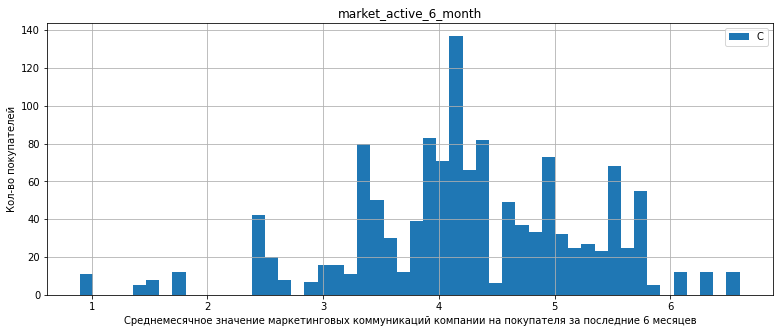

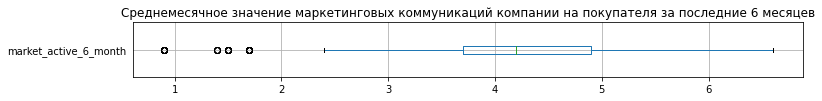

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: market_active_6_month, dtype: float64


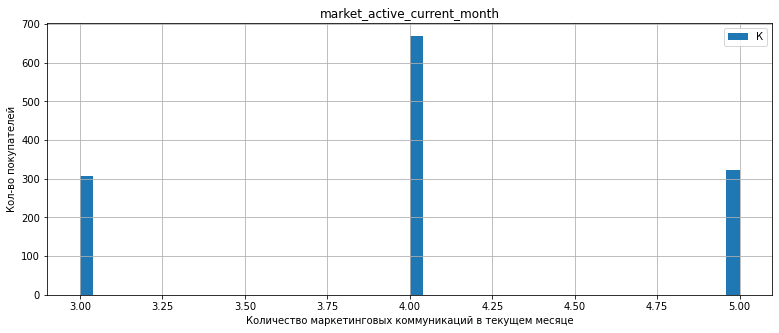

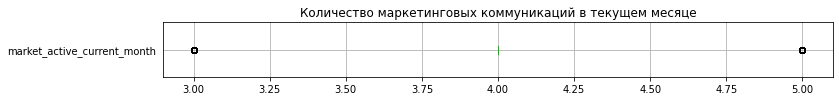

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: market_active_current_month, dtype: float64


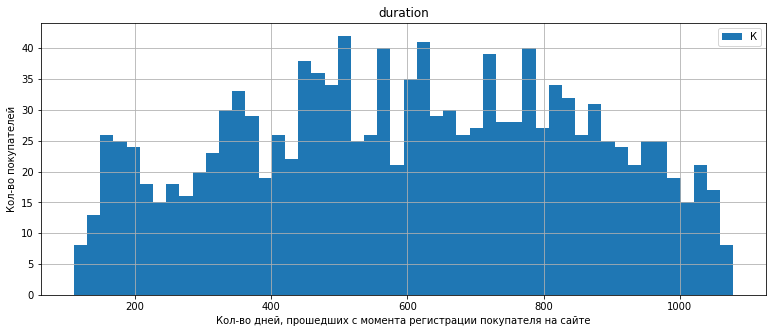

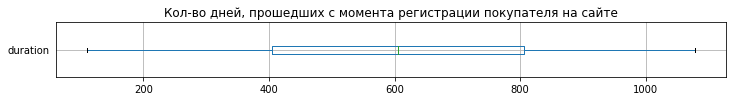

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: duration, dtype: float64


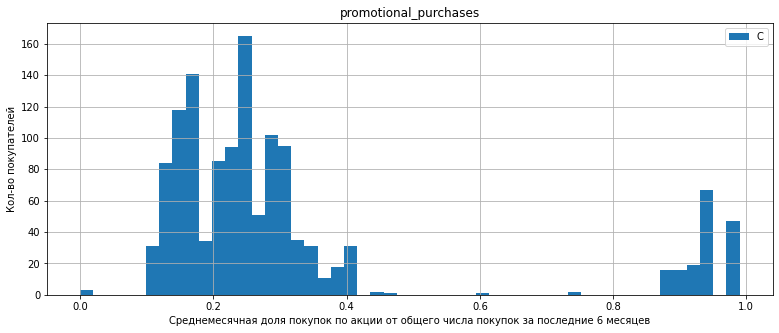

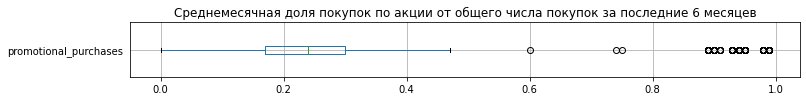

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: promotional_purchases, dtype: float64


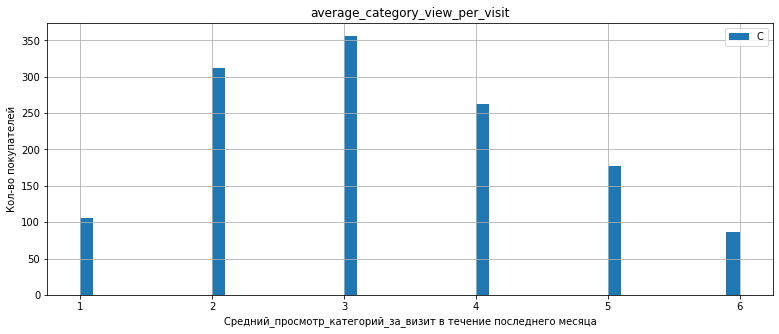

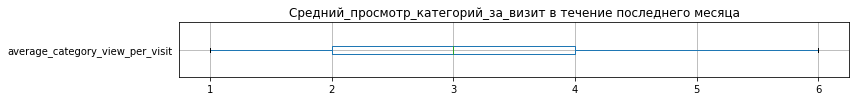

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: average_category_view_per_visit, dtype: float64


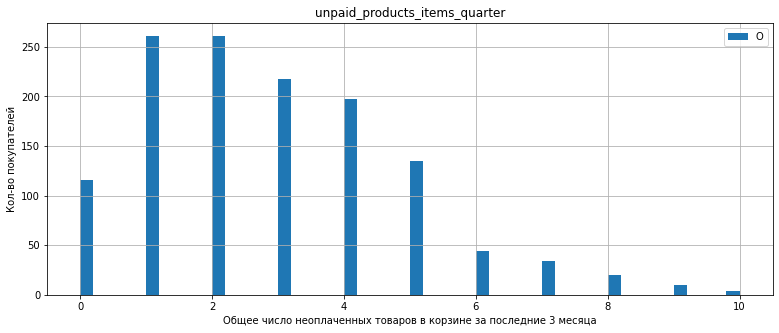

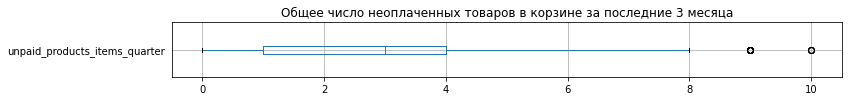

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_products_items_quarter, dtype: float64


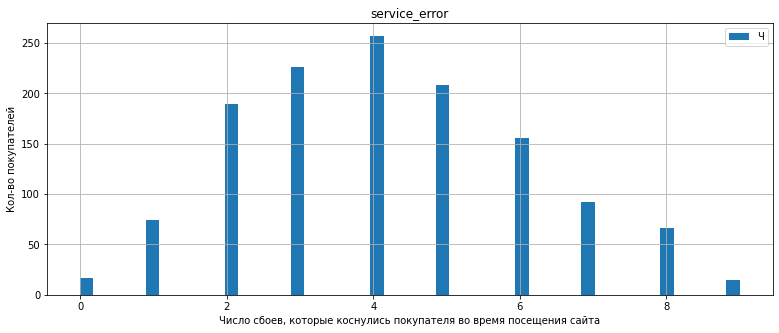

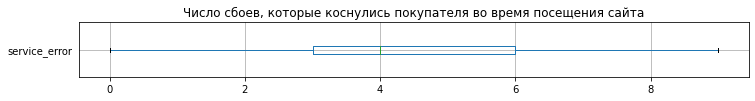

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: service_error, dtype: float64


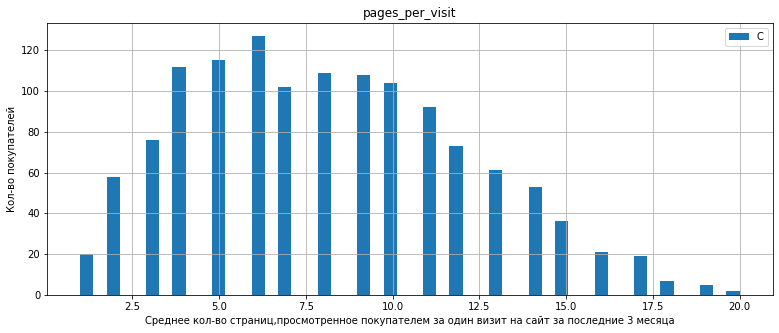

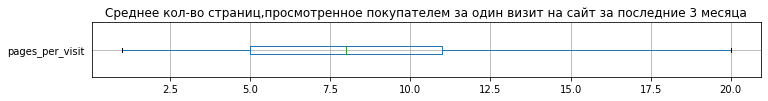

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: pages_per_visit, dtype: float64


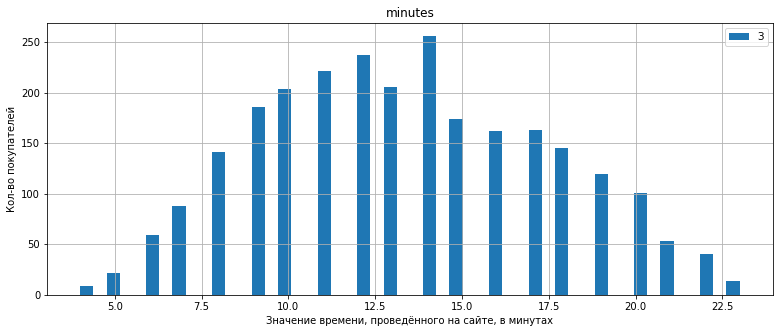

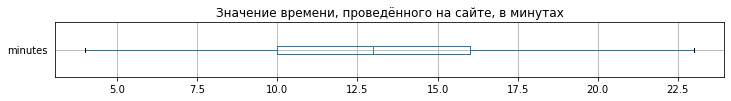

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes, dtype: float64


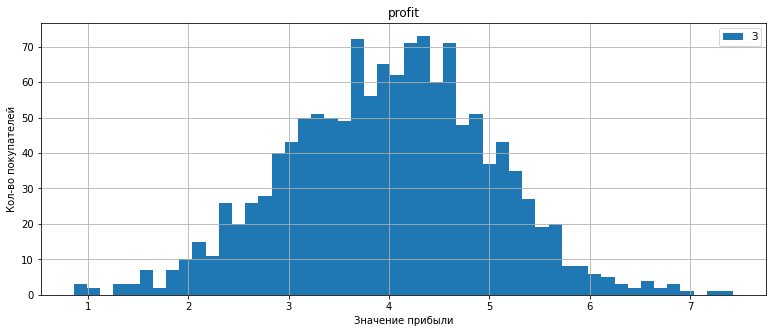

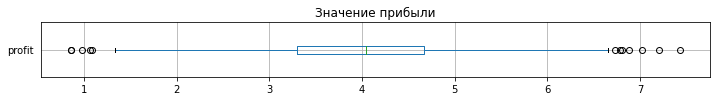

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: profit, dtype: float64


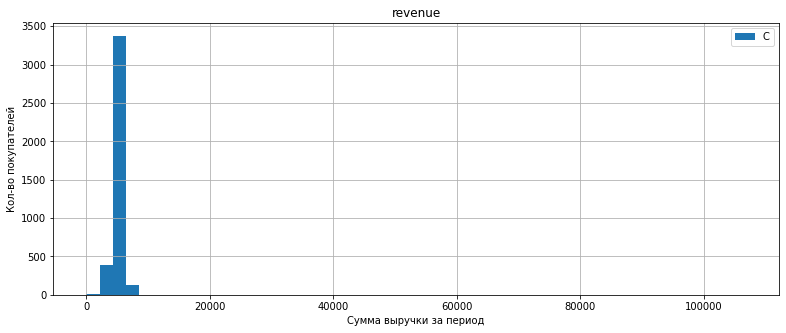

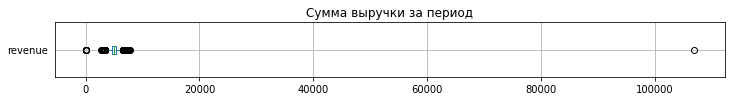

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: revenue, dtype: float64


In [41]:
data_analysis(market_file, 'market_active_6_month',\
'Cреднемесячное значение маркетинговых коммуникаций компании на покупателя за последние 6 месяцев')

data_analysis(market_file, 'market_active_current_month',\
'Количество маркетинговых коммуникаций в текущем месяце')

data_analysis(market_file, 'duration',\
'Кол-во дней, прошедших с момента регистрации покупателя на сайте')

data_analysis(market_file, 'promotional_purchases',\
'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')

data_analysis(market_file, 'average_category_view_per_visit',\
'Средний_просмотр_категорий_за_визит в течение последнего месяца')

data_analysis(market_file, 'unpaid_products_items_quarter',\
'Общее число неоплаченных товаров в корзине за последние 3 месяца')

data_analysis(market_file, 'service_error',\
 'Число сбоев, которые коснулись покупателя во время посещения сайта')

data_analysis(market_file, 'pages_per_visit',\
'Среднее кол-во страниц,просмотренное покупателем за один визит на сайт за последние 3 месяца')

data_analysis(market_time, 'minutes',\
'Значение времени, проведённого на сайте, в минутах')

data_analysis(money, 'profit',\
'Значение прибыли')

data_analysis(market_money, 'revenue',\
'Сумма выручки за период')

**Так как в данных 'revenue' присутствует выброс данных, при построении гистограммы возникли проблемы с масштабированием. Поэтому для лучшей визуализации построим гистограмму с границами range = (0, 8000):**

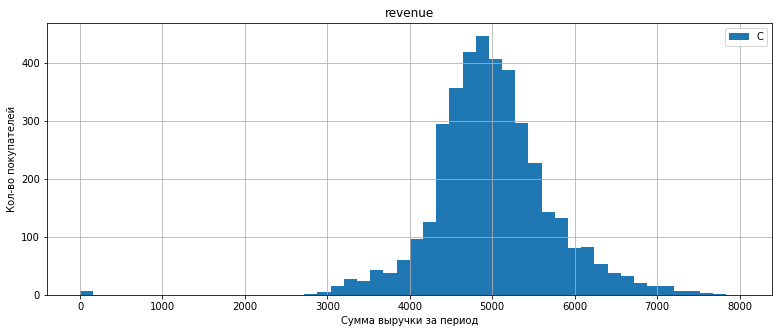

In [42]:
market_money['revenue'].hist(range = (0, 8000),bins = 50,\
    grid = True,figsize = (13,5))
plt.title('revenue')
plt.xlabel('Сумма выручки за период')
plt.ylabel('Кол-во покупателей')
plt.legend('Сумма выручки за период');
plt.show();

**Краткое описание данных:**

- **market_active_6_month:**
Распределение близкое к нормальному. Средняя покупательская активность меньше 2 операций выделяется из распределения, что подтверждается боксплотом. Пока удалять эти выбросы не будем, так как они отразают клиентов с малой активностью.

- **market_active_current_month:**
Несмотря на малую вариацию значений (3, 4, 5 операций), "нормальность" прослеживается. Также отсутствуют аномально малые значения мельше 3, что подтверждает правильность намерения отсечь клиентов с покупательной активностью менее 3 месяцев.

- **duration:**
Распределение близкое к нормальному,хотя колокол растянут.Несмотря на то, что пик колокола прослеживается, в распределении присутствует составляющая равномерного распределения. Медианное значение duration почти равно среднему, аномальных выбросов не наблюдается.
**Отметим, последний пользователь зарегистрировался на сайте 110 дней назад - это более 3-х месяцев.**

- **promotional_purchases:**
Основная группа значений (0 - 0.5) близка к нормальному распределению.Медианное значение 0.24, наблюдается выброс значений  в интервале 0.85 - 1.0 покупки за 6 мес.

In [43]:
#Кол-во аномальных покупок по акциям
market_file.loc[market_file['promotional_purchases'] > 0.75]['id'].count()

165

Аномальных покупок по акциям 165.Это 12.6% от общего числа клиентов.

<font color='blue'><b>Следовательно, наблюдаем две группы покупателей, одна из которых приобретает товары почти исключительно по акциям. Далее в исследовании на этот факт следует обратить внимание. </b></font><br>


- **average_category_view_per_visit:**
Нормальное распределение с небольшим смещением влево.Ближе к распределению Пуассона.Выбросов нет.

- **unpaid_products_items_quarter:**
Похоже на распределение Пуассона. Наблюдаются аномальные значения более 8 неоплаченных товаров в корзине.

In [44]:
market_file.loc[market_file['unpaid_products_items_quarter'] > 8]['id'].count()

14

Таких значений 14.Пока оставим.Если эти значения будут оказывать влияние при построении моделей, тогда удалим.

- **service_error:**
Нормальное распределение без выбросов.

- **pages_per_visit:**
Нормальное распределение с небольшим смещением влево, если не считать аномалии в районе 4 - 6 страниц просмотра. Скорее всего это некое комфортное число просматриваемых страниц. Отметим это как особенность психологии пользователей.

- **revenue:**
Типичное нормальное распределение.Медианное значение выручки составляет порядка 5000 рублей за период.Присуствует аномальное значение 106862 рубля.

In [45]:
market_money.loc[market_money['revenue'] > 10000]

id         period   revenue
98  215380  текущий_месяц  106862.2

Клиент id = 215380 аномальный. Его следует удалить из датафрейма.

- **minutes:**
Нормальное распределение.Медианное время, проведенное на сайте в районе 13 минут.

- **profit:**
Нормальное распределение.Отметим выбросы на отрезке больше 7000 руб.Пока оставляем.

<font color='green'><b> Распределение времени, проведённом на сайте, по периодам. </b></font><br>

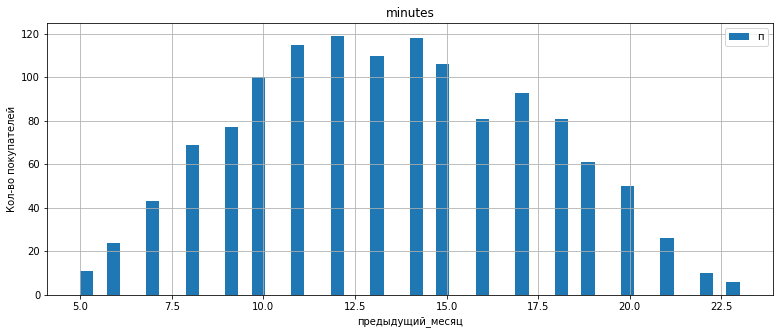

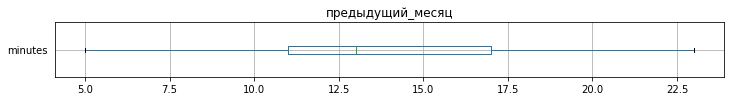

count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: minutes, dtype: float64


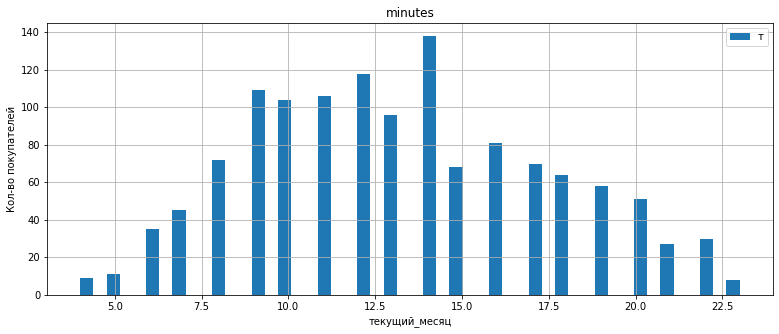

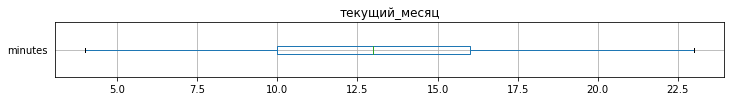

count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes, dtype: float64


In [46]:
source = ['предыдущий_месяц','текущий_месяц',]
for a in source:
    data_analysis(market_time.loc[market_time['period'] == a],\
    'minutes', a)

Среднее время, проведенное на сайте, практически не изменилось.Однако поменялась форма распределения.Также в текущем месяце появилось увеличенное кол-во пользователей - около 140, находящихся на сайте 14 минут. В предыдущем месяце распределение нормальное, а в текущем тоже близкое к нормальному, при этом наблюдается небольшое смещение влево (в сторону уменьшения времени).Можно сказать, что график начинает "плыть" в сторону уменьшения времени нахождения на сайте.

<font color='blue'><b>Вывод по пункту 3.1:</b></font><br>

1. Распределение рассмотренных количественнных данных близко к нормальному.Выбросы есть, но незначительные.
2. Есть  клиент id = 215380 с аномально большой выручкой.Кандидат на уданение.
3. Выявлены  две группы покупателей, одна из которых приобретает товары почти исключительно по акциям. Далее в исследовании на этот факт следует обратить внимание.**

### КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ

Рассмотрим основной файл market_file в разрезе категориальных признаков.Помимо долевой оценки признаков как таковых, рассмотрим их в разрезе влияния на количественные признаки.
Для этого создадим функцию "diagramm", с помощью которой сформируем столбчатые гистограммы распределения количественных параметров.

In [47]:
def diagramm(cat_param, cat_value_1, cat_value_2):
    category = ['market_active_6_month','market_active_current_month', 'duration',\
    'promotional_purchases','average_category_view_per_visit','unpaid_products_items_quarter',\
    'service_error','pages_per_visit']
    
    market_file[cat_param].value_counts().plot(figsize = (6,6),
    kind = 'pie', autopct = '%1.2f%%')
    plt.title(cat_param)
    plt.show();         
    
    for i in category:
        plt.hist([market_file.loc[market_file[cat_param] == cat_value_1][i],\
        market_file.loc[market_file[cat_param] == cat_value_2][i]],\
        bins=100, stacked=True,color=['cyan', 'Purple'], edgecolor='black')
        plt.xlabel(i)
        plt.ylabel('Кол-во покупателей')
        plt.title(i)
        plt.legend([f'{cat_param},{cat_value_1}',\
        f'{cat_param},{cat_value_2}']);
        plt.show()   
          

<font color='green'><b>  buying_activity - покупательская активность: </b></font><br>

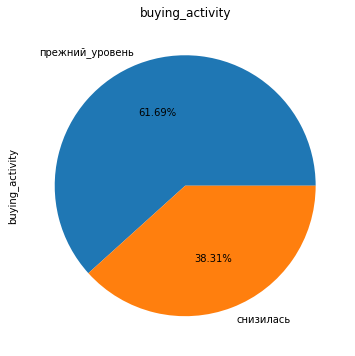

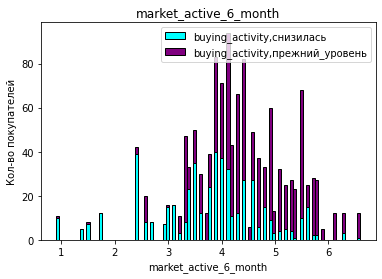

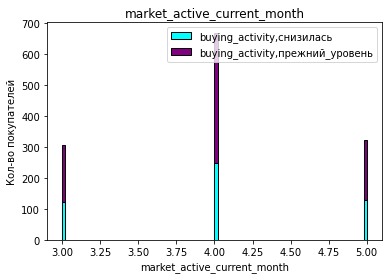

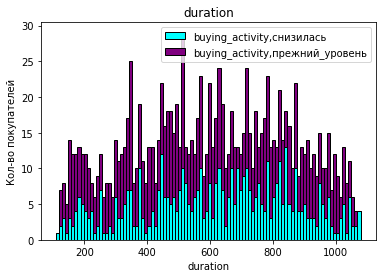

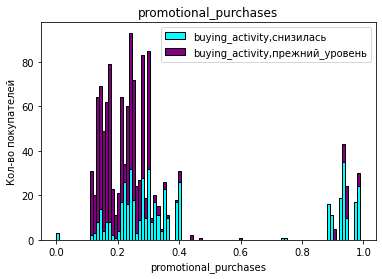

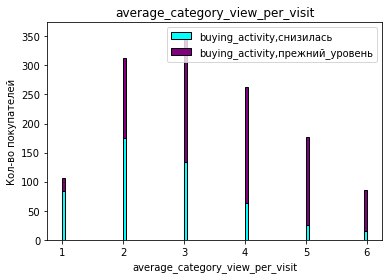

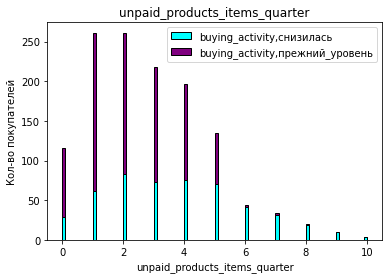

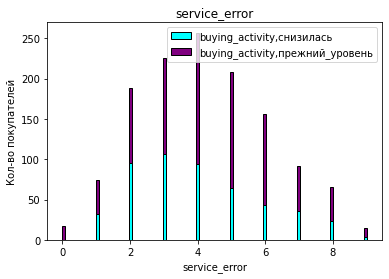

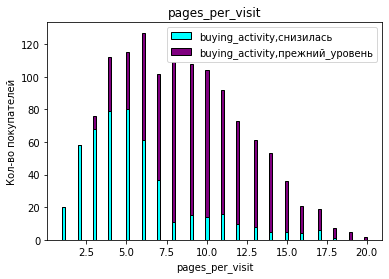

In [48]:
diagramm('buying_activity', 'снизилась', 'прежний_уровень')

Примерно у трети клиентов (38.31%) наблюдается снижение покупательской активности.Опишем взаимосвязь 'buying_activity' с другими признакнами:

- **market_active_6_month** - те клиенты, у которых число коммуникаций было меньше 3-х, они почти все снизили покупательскую активность (см. столбчатая диаграмма)
- **market_active_current_month** - в текущем месяце покупательская активность уже снижена вне зависимости от кол-ва коммуникаций.То есть у кого устойчивый интерес к продукции, тот покупает вне зависимости от коммуникаций,  а у кого неустойчивый - на того уже коммуникации не влияют. Плохая теденция - падение интереса со стороны клиентов
- **duration** - активность снизилась у всех в схожей пропорции: как у постоянных клиентов, так и у новых.
- **promotional_purchases** - наибольшая доля снижения активности у любителей покупать по акции 0.8 - 1.0 покупок за 6 мес.Клиенты, мало покупающие по акции - 0.1 - 0.3 покупки за 6 мес.,незначительно снизили активность.То есть те, у кого устойчивый интерес к продукции сайта, на них акции слабо влияют.А у любителей акций упал интерес, значит, кол-во акций уменьшается.
 - **average_category_view_per_visit** - наибольшая доля снижения интереса у тех, кто мало просматривает категорий. Почти полное снижение интереса у тех, кто просматривает 1 категорию.Далее чем больше просматривается категорий, тем устойчивее интерес.Иными словами, малый просмотр сайта является покзателем снижения интереса.
 - **unpaid_products_items_quarter** - как и в предыдущем, чем больше остается неоплаченных товаров в корзине - больше 6-ти, тем ниже интерес.Хороший показатель снижения активности клиентов.
 - **service_error** - число сбоев на сайте не влияет на активность клиентов.
 - **pages_per_visit** - Также хороший показатель снижения активности. Почти все, кто смотрит меньше 3-х страниц за посещение, демонстрируют снижение активности.

Вывод: целевой параметр **buying_activity** зависит от всех количественных параметров, кроме **duration** и **service_error**.

<font color='green'><b> service_type - тип подписки клиентов: </b></font><br>

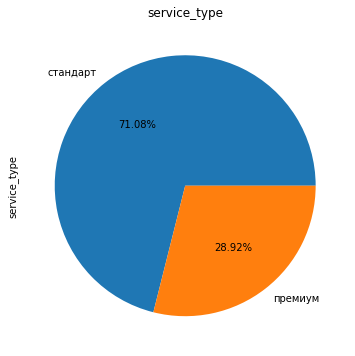

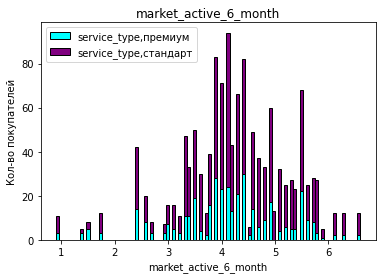

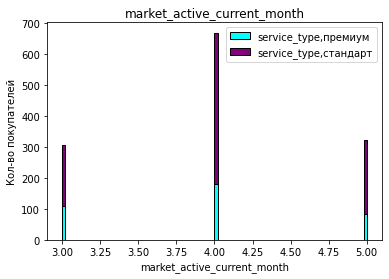

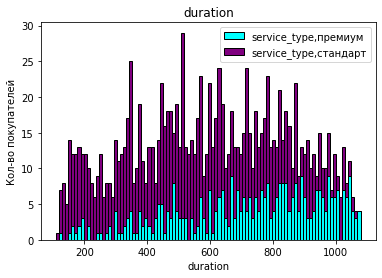

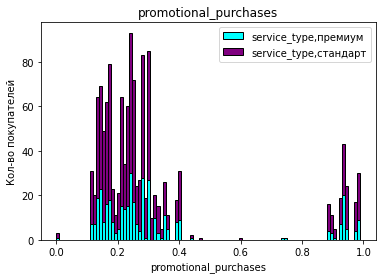

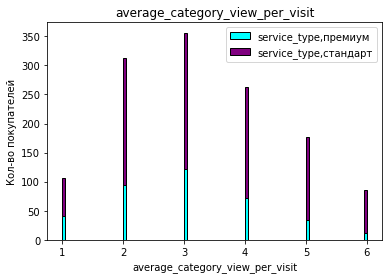

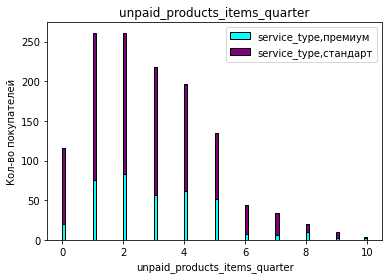

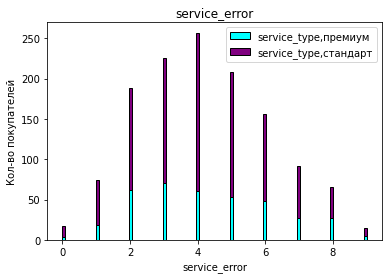

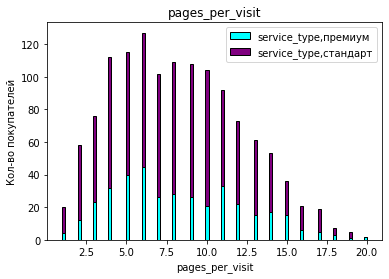

In [49]:
diagramm('service_type', 'премиум', 'стандарт')

Большинство клиентов 71.08% предпочитают стандартный тип сервиса.Причем влияние типа сервиса на количественные показатели незначительно - типы сервиса представлены в показателях схожими пропорциями.Отметим, что на графике **duration** хорошо видно, что доля подписчиков ПРЕМИУМ растет у "старых" клиентов.У тех,кто недавно зарегистрировался на сайте - малая доля подписки ПРЕМИУМ.

<font color='green'><b> allow_reporting -  информация о том, можно ли присылать покупателю дополнительные предложения о товаре: </b></font><br>

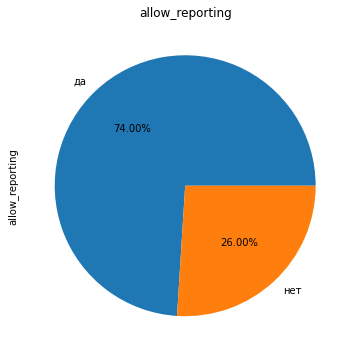

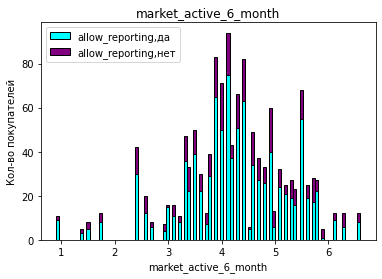

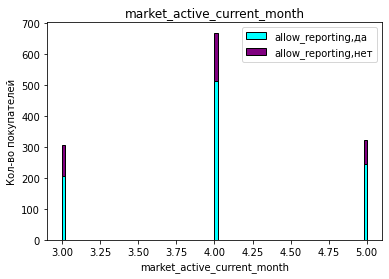

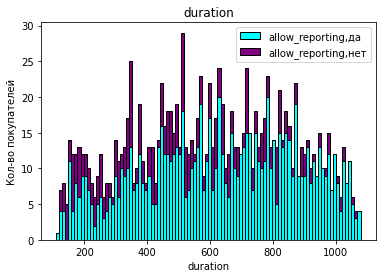

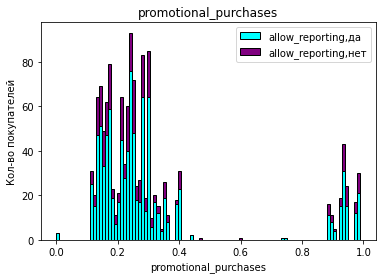

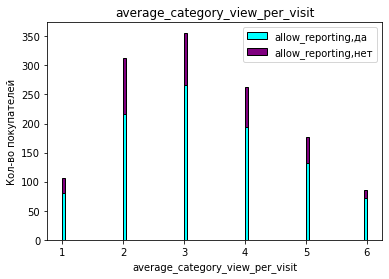

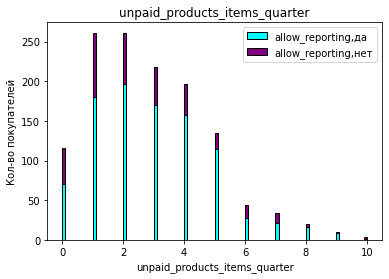

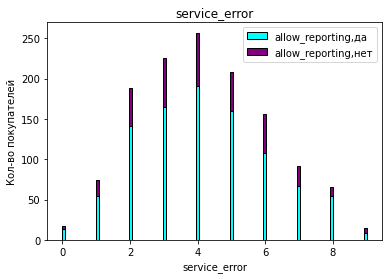

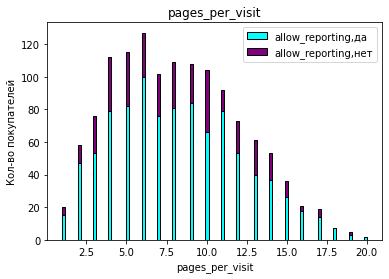

In [50]:
diagramm('allow_reporting', 'да', 'нет')

74% клиентов получают дополнительные предложения.Влияние получения доп. предложений влияет на количественные показатели незначительно -  наблюдаются схожие пропорции признака в гисторгаммах. Возможно, стоит поработать над составом предложений, если они не вызывают интерес.

<font color='green'><b>  popular_category  — самая популярная категория товаров у покупателя за последние 6 месяцев: </b></font><br>

Для популярных категорий создадим отдельную функцию "diagramm_pop_cat".

In [51]:
   def diagramm_pop_cat():
    #Категории, в разрезе которых рассматриваем популярные категории товаров    
    category = ['market_active_6_month','market_active_current_month', 'duration',\
    'promotional_purchases','average_category_view_per_visit','unpaid_products_items_quarter',\
    'service_error','pages_per_visit']
    #Популярные категории товаров
    pop_categ = ['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
    'техника_для_красоты_и_здоровья', 'кухонная_посуда', 'мелкая_бытовая_техника_и_электроника']
    
    #Построение круговой диаграммы
    market_file['popular_category'].value_counts().plot(figsize = (7,7),
    kind = 'pie', autopct = '%1.2f%%')
    plt.title('popular_category')
    plt.show();         
    
    #Построение совмещенных графиков популярных категорий
    for i in category:
        for a in pop_categ:
            market_file.loc[market_file['popular_category'] == a].\
            groupby(i)['id'].count().\
            plot(x=i,y='id',grid = True,figsize = (12,10)) 
            plt.title(i)
            plt.xlabel(i)
            plt.ylabel('Кол-во покупателей');
        
        plt.show(); 

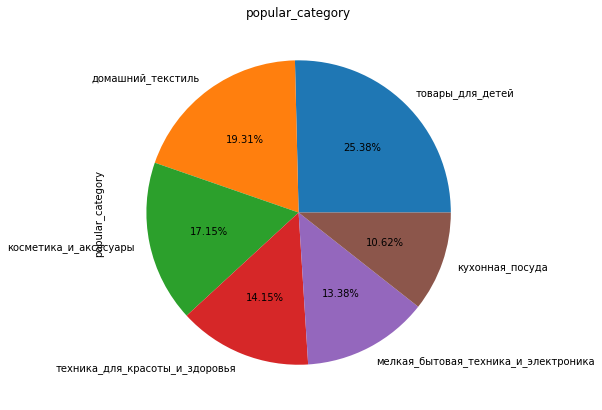

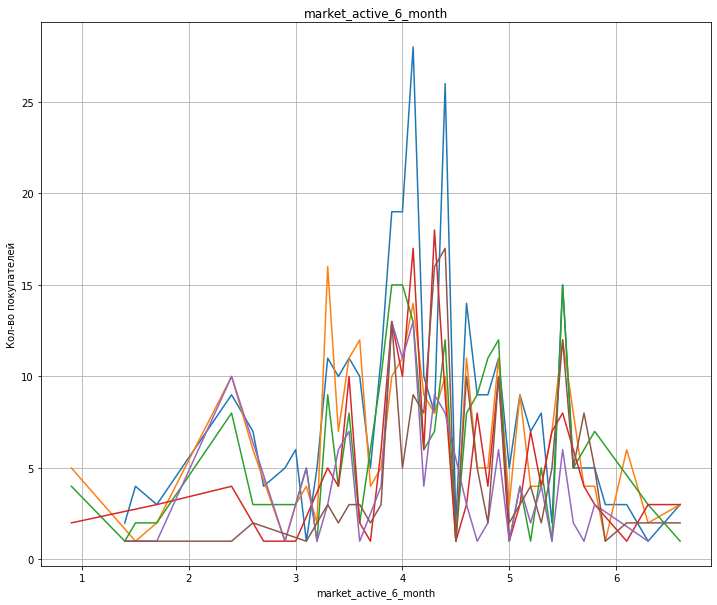

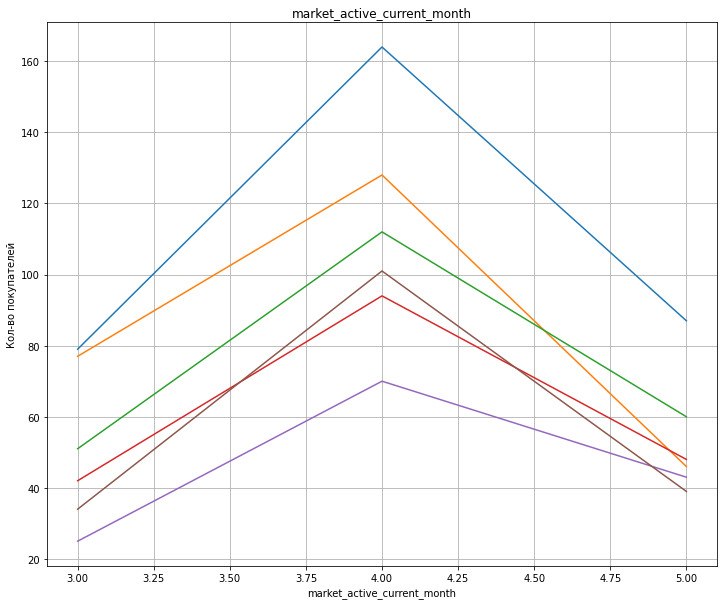

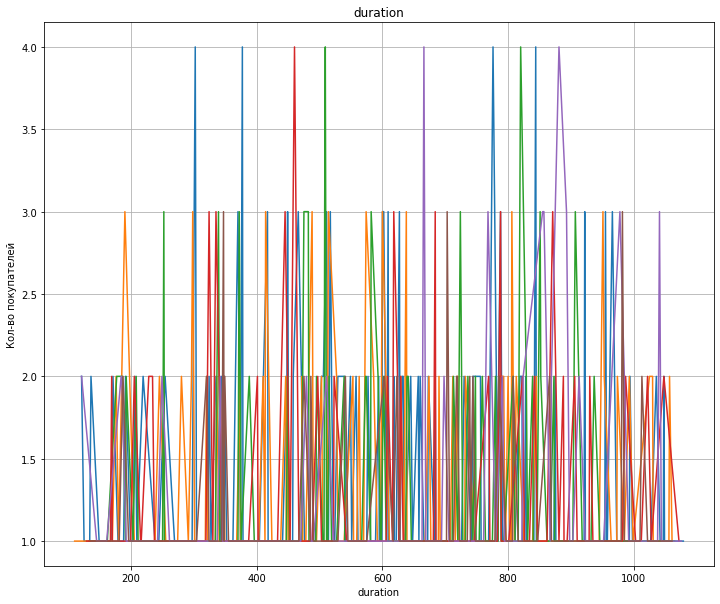

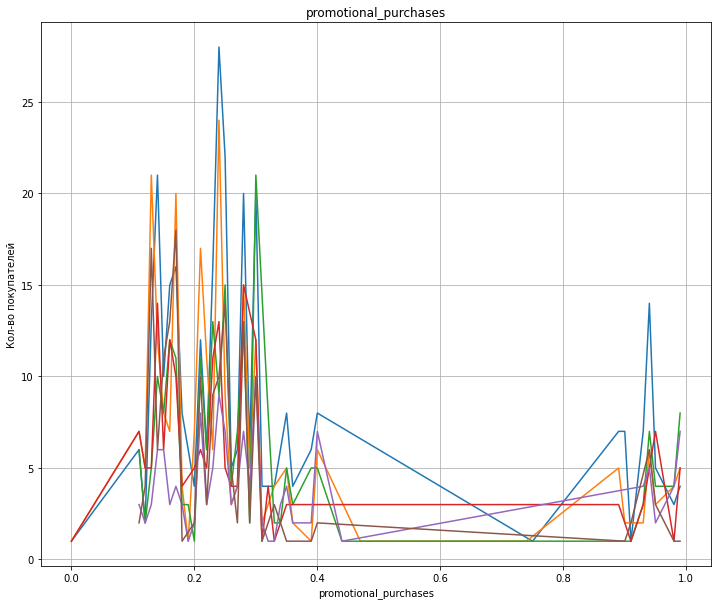

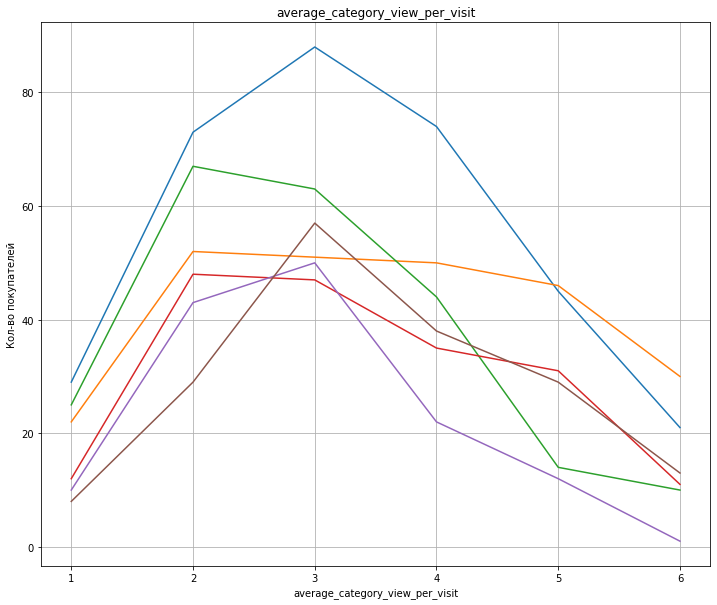

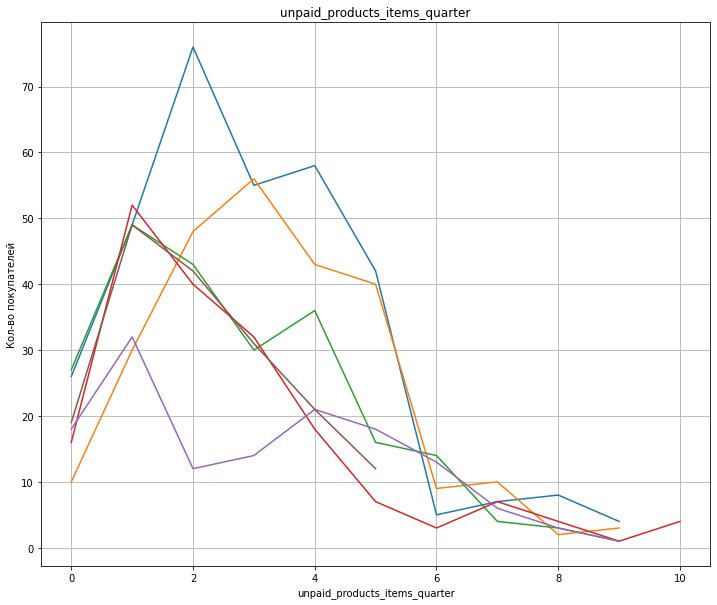

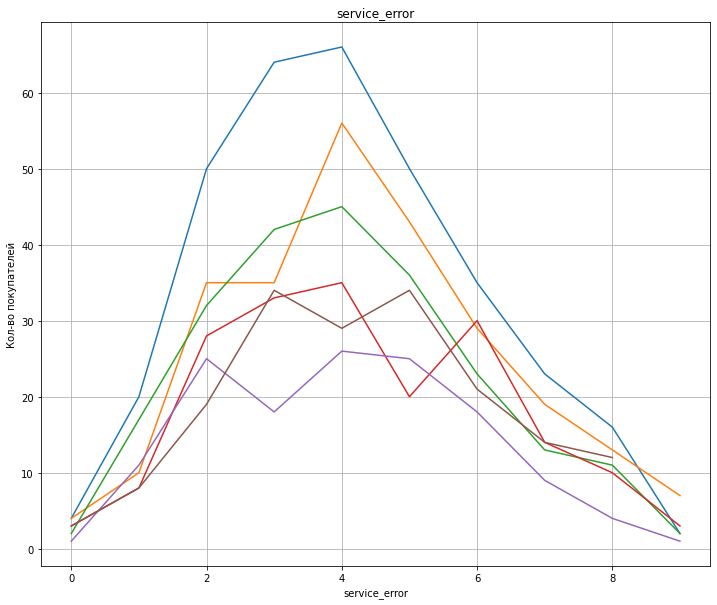

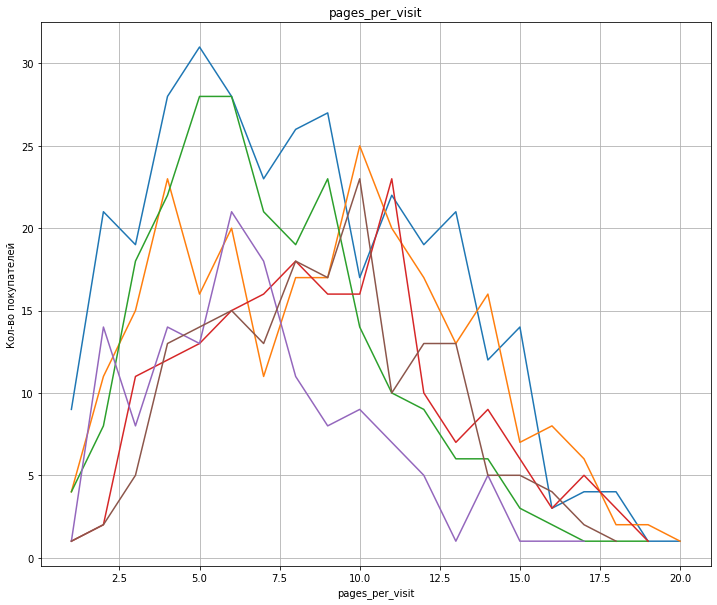

In [52]:
diagramm_pop_cat()

Наиболее популярны товары для детей 25,28%.На 2 месте домашний текстиль 19.31%. Остальные равномерно уменьшаются до 10.62% - кухонная посуда.В общем, аномалий не наблюдается. 

Примечательно, что наиболее удачные акции по детским товарам.


**Вывод:**

Влияние категориальных признаков на количественные пропорционально долевому соотношению значений самих категориальных признаков.Каких-либо аномалий не обнаружено.

Наиболее удачные акции по детским товарам.

#### <font color='green'><b> Рассмотрим подробно категорию  "promotional_purchases"</b></font><br>

<a id='8745'></a>
[К пункту 8.2.10](#8744)

Ранее в п.3.1 и п.3.2 мы обнаружили наличие в акционных покупках отдельную группу покупателей с долей акционных покупок больше 0.7.Посмотрим, что влияет на эту группу и как она соотносится в общим датасетом.

In [53]:
#Сформируем отдельный датасет с promotional_purchases > 0.7
promotional_purchases_2 = market_file.loc[(market_file['promotional_purchases'] > 0.7)]

In [54]:
promotional_purchases_2.describe(include='all').T

count unique               top freq  \
id                               167.0    NaN               NaN  NaN   
buying_activity                    167      2         снизилась  134   
service_type                       167      2          стандарт  112   
allow_reporting                    167      2                да  119   
market_active_6_month            167.0    NaN               NaN  NaN   
market_active_current_month      167.0    NaN               NaN  NaN   
duration                         167.0    NaN               NaN  NaN   
promotional_purchases            167.0    NaN               NaN  NaN   
popular_category                   167      6  товары_для_детей   49   
average_category_view_per_visit  167.0    NaN               NaN  NaN   
unpaid_products_items_quarter    167.0    NaN               NaN  NaN   
service_error                    167.0    NaN               NaN  NaN   
pages_per_visit                  167.0    NaN               NaN  NaN   

                                          mean         std       min  \
id                               215753.083832  384.093165  215349.0   
buying_activity                            NaN         NaN       NaN   
service_type                               NaN         NaN       NaN   
allow_reporting                            NaN         NaN       NaN   
market_active_6_month                 3.769461    1.087315       0.9   
market_active_current_month           3.976048    0.702423       3.0   
duration                            604.251497  239.852156     147.0   
promotional_purchases                 0.942695    0.038299      0.74   
popular_category                           NaN         NaN       NaN   
average_category_view_per_visit       2.808383    1.293795       1.0   
unpaid_products_items_quarter         3.634731    2.474835       0.0   
service_error                         4.131737    1.828657       0.0   
pages_per_visit                       5.718563    3.265162       1.0   

                                      25%       50%       75%       max  
id                               215480.5  215625.0  215843.0  216647.0  
buying_activity                       NaN       NaN       NaN       NaN  
service_type                          NaN       NaN       NaN       NaN  
allow_reporting                       NaN       NaN       NaN       NaN  
market_active_6_month                3.25       4.0       4.4       5.7  
market_active_current_month           3.0       4.0       4.0       5.0  
duration                            437.0     618.0     800.5    1064.0  
promotional_purchases                0.93      0.94      0.98      0.99  
popular_category                      NaN       NaN       NaN       NaN  
average_category_view_per_visit       2.0       3.0       4.0       6.0  
unpaid_products_items_quarter         2.0       3.0       5.0      10.0  
service_error                         3.0       4.0       5.0       8.0  
pages_per_visit                       3.0       5.0       7.0      15.0

167 строк в датасете

In [55]:
#Создадим функцию
# Влияние признаков на promotional_purchases
def comparison_сategory_action (x):
    tabl = pd.concat([market_file[x].value_counts(),\
    promotional_purchases_2[x].value_counts()], axis=1)

    tabl.columns= ['Кол-во в market_file', 'Кол-во в promotional_purchases_2']
    
    tabl['(%) от общего кол-ва market_file'] = round(((tabl['Кол-во в market_file']\
    / market_file['popular_category'].count()))*100,2)
    
    tabl['(%) от общего кол-ва promotional_purchases_2'] = round(((tabl['Кол-во в promotional_purchases_2']\
    / promotional_purchases_2['popular_category'].count()))*100,2)    
    
     
    tabl['Разница в  (%)'] = tabl['(%) от общего кол-ва promotional_purchases_2']\
    - tabl['(%) от общего кол-ва market_file']
    
    
    tabl['На сколько (%) изменились (%)promotional_purchases_2 от (%)market_file'] = ((tabl['(%) от общего кол-ва promotional_purchases_2']\
    - tabl['(%) от общего кол-ва market_file'])/tabl['(%) от общего кол-ва market_file']*100).round(2)
    
    return tabl

In [56]:
   def diagramm_pop_cat1():
    #Категории, в разрезе которых рассматриваем популярные категории товаров    
    category = ['promotional_purchases']
    #Популярные категории товаров
    pop_categ = ['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
    'техника_для_красоты_и_здоровья', 'кухонная_посуда', 'мелкая_бытовая_техника_и_электроника']
    
    #Построение круговой диаграммы
    promotional_purchases_2['popular_category'].value_counts().plot(figsize = (7,7),
    kind = 'pie', autopct = '%1.2f%%')
    plt.title('popular_category')
    plt.show();               
    
    #Построение совмещенных графиков популярных категорий
    for i in category:
        for a in pop_categ:
            promotional_purchases_2.loc[promotional_purchases_2['popular_category'] == a].\
            groupby(i)['id'].count().\
            plot(x=i,y='id',grid = True,figsize = (12,10)) 
            plt.title('promotional_purchases_2')
            plt.xlabel(i)
            plt.ylabel('Кол-во покупателей');
        
        plt.show(); 

In [57]:
comparison_сategory_action ('popular_category')

Кол-во в market_file  \
товары_для_детей                                       330   
домашний_текстиль                                      251   
косметика_и_аксесуары                                  223   
техника_для_красоты_и_здоровья                         184   
мелкая_бытовая_техника_и_электроника                   174   
кухонная_посуда                                        138   

                                      Кол-во в promotional_purchases_2  \
товары_для_детей                                                    49   
домашний_текстиль                                                   28   
косметика_и_аксесуары                                               29   
техника_для_красоты_и_здоровья                                      25   
мелкая_бытовая_техника_и_электроника                                14   
кухонная_посуда                                                     22   

                                      (%) от общего кол-ва market_file  \
товары_для_детей                                                 25.38   
домашний_текстиль                                                19.31   
косметика_и_аксесуары                                            17.15   
техника_для_красоты_и_здоровья                                   14.15   
мелкая_бытовая_техника_и_электроника                             13.38   
кухонная_посуда                                                  10.62   

                                      (%) от общего кол-ва promotional_purchases_2  \
товары_для_детей                                                             29.34   
домашний_текстиль                                                            16.77   
косметика_и_аксесуары                                                        17.37   
техника_для_красоты_и_здоровья                                               14.97   
мелкая_бытовая_техника_и_электроника                                          8.38   
кухонная_посуда                                                              13.17   

                                      Разница в  (%)  \
товары_для_детей                                3.96   
домашний_текстиль                              -2.54   
косметика_и_аксесуары                           0.22   
техника_для_красоты_и_здоровья                  0.82   
мелкая_бытовая_техника_и_электроника           -5.00   
кухонная_посуда                                 2.55   

                                      На сколько (%) изменились (%)promotional_purchases_2 от (%)market_file  
товары_для_детей                                                                  15.60                       
домашний_текстиль                                                                -13.15                       
косметика_и_аксесуары                                                              1.28                       
техника_для_красоты_и_здоровья                                                     5.80                       
мелкая_бытовая_техника_и_электроника                                             -37.37                       
кухонная_посуда                                                                   24.01

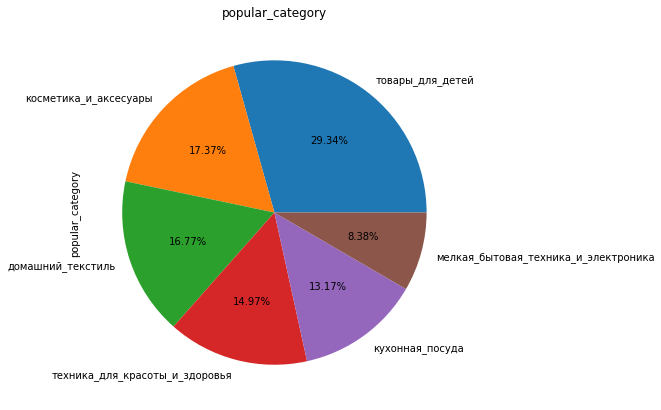

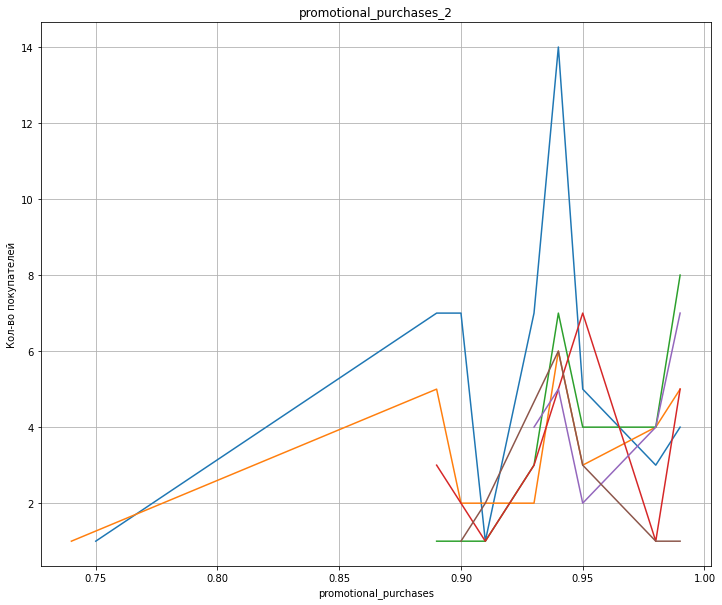

In [58]:
diagramm_pop_cat1()

В акционных покупках также лидируют **товары_для_детей**,также состав **promotional_purchases_2** пропорционален общему датасету 

**Соотношение service_type в promotional_purchases_2  :**

In [59]:
comparison_сategory_action ('service_type')

Кол-во в market_file  Кол-во в promotional_purchases_2  \
стандарт                   924                               112   
премиум                    376                                55   

          (%) от общего кол-ва market_file  \
стандарт                             71.08   
премиум                              28.92   

          (%) от общего кол-ва promotional_purchases_2  Разница в  (%)  \
стандарт                                         67.07           -4.01   
премиум                                          32.93            4.01   

          На сколько (%) изменились (%)promotional_purchases_2 от (%)market_file  
стандарт                                              -5.64                       
премиум                                               13.87

В **promotional_purchases_2** на 4% выросла доля подписки ПРЕМИУМ.

Влияние **unpaid_products_items_quarter** на **promotional_purchases :**

Построим скатеерплот.Изменение окраса точек обеспечим значениями категорий
- duration,
- market_active_current_month,
- market_active_6_month,
- pages_per_visit** 

In [60]:
#duration
fig = px.scatter(market_file, x="promotional_purchases", y="unpaid_products_items_quarter", color="duration")
fig.show()

Интересных зависимостей не прослеживается.

In [61]:
#market_active_current_month
fig = px.scatter(market_file, x="promotional_purchases", y="unpaid_products_items_quarter", color="market_active_current_month")
fig.show()

Интересных зависимостей не прослеживается.

In [62]:
#market_active_6_month
fig = px.scatter(market_file, x="promotional_purchases", y="unpaid_products_items_quarter", color="market_active_6_month")
fig.show()

У акционных покупателей, в корзине у которых находится больше 5 товаров, замечено небольшое снижение активности.

In [63]:
#pages_per_visit
fig = px.scatter(market_file, x="promotional_purchases", y="unpaid_products_items_quarter", color="pages_per_visit")
fig.show()

У акционных покупателей, в корзине у которых находится больше 5 товаров, замечено явное снижение кол-ва просмотренных страниц за визит.

#### <font color='green'><b> Посмотрим, зависит ли падение уровня покупательской (целевой признак) активности от других категориальных признаков. </b></font><br>

In [64]:
#Создадим функцию
# Влияние признаков на снижение покупательской активности
def buying_activity_corr (x):
    tabl = pd.concat([market_file.loc[market_file['buying_activity'] == 'снизилась'][x].value_counts(),\
    market_file[x].value_counts()], axis=1)

    tabl.columns= ['Снижение покупательской активности', 'Общее кол-во']

    tabl['Снижение покупательской активности в (%) от общего кол-ва'] = round(((tabl['Снижение покупательской активности']\
    / tabl['Общее кол-во']))*100,2)

    return tabl

<font color='black'><b> Снижение покупательской активности в зависимости от типа подписки. </b></font><br>

In [65]:
buying_activity_corr ('service_type')

Снижение покупательской активности  Общее кол-во  \
стандарт                                 328           924   
премиум                                  170           376   

          Снижение покупательской активности в (%) от общего кол-ва  
стандарт                                              35.50          
премиум                                               45.21

Снижение покупательской активности у клиентов премиум на 10% больше, чем у стандарт.

<font color='black'><b> Снижение покупательской активности в зависимости от получения рассылок. </b></font><br>

In [66]:
buying_activity_corr ('allow_reporting')

Снижение покупательской активности  Общее кол-во  \
да                                  371           962   
нет                                 127           338   

     Снижение покупательской активности в (%) от общего кол-ва  
да                                               38.57          
нет                                              37.57

Снижение покупательской активности не зависит от получения клиентами рассылок: наблюдаем практически равные доли в снижении активности 38.57% и 37.57%. **Возможно, содержание рассылок не вызывает интереса.**

<font color='black'><b>Снижение покупательской активности в зависимости от популярной категории товара. </b></font><br>

<a id='1243'></a>
 [См.также анализ важности признаков](#1244)

In [67]:
buying_activity_corr ('popular_category')\
['Снижение покупательской активности в (%) от общего кол-ва'].sort_values()

мелкая_бытовая_техника_и_электроника    15.52
техника_для_красоты_и_здоровья          28.26
домашний_текстиль                       40.64
товары_для_детей                        44.24
косметика_и_аксесуары                   47.09
кухонная_посуда                         47.83
Name: Снижение покупательской активности в (%) от общего кол-ва, dtype: float64

<font color='blue'><b>Наименьшее снижение покупательской активности у категории "мелкая_бытовая_техника _ и _электроника" - 15.52%, хотя это одна из наименее популярных категорий товара. </b></font><br>



Наибольшее снижение покупательской активности у клиентов с любимыми категориями "кухонная_посуда" и "косметика_и_аксесуары" 47.83% и 47.09%.Немного меньше, но достаточно высокое у наиболее популярных категорий товаров "товары_для_детей" - 44.24% и "домашний_текстиль" - 40.64%.

#### <font color='green'><b> Отберем клиентов с покупательской активностью не менее трёх месяцев, которые каждый месяц делали покупки. </b></font><br>

Необходимые данные возьмем из таблицы "market_money", в которой отражена выручка за 3 месяца:текущий месяц, предыдущий и препредыдущий.То есть выберем таких клиентов, у которых за какой-либо из этих 3 месяцев выручка была равно нулю. 

In [68]:
market_money.loc[market_money['revenue'] == 0]['id'].unique()

array([215348, 215357, 215359])

Клиенты с "id" 215348, 215357, 215359 имеют нулевые выручки в 3-х месячном периоде.Строки с этими "id", а также строку с аномально высокой выручкой "id" = 215380 удалим после объединения датафреймов.

### Вывод

**КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ**

- **market_active_6_month** - Cреднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев:

Распределение близкое к нормальному. Средняя покупательская активность меньше 3 операций выделяется из распределения, что подтверждается боксплотом. Пока удалять эти выбросы не будем, так как они отражают клиентов с малой активностью.

- **market_active_current_month** — количество маркетинговых коммуникаций в текущем месяце:

Несмотря на малую вариацию значений (3, 4, 5 операций), "нормальность" прослеживается. Также отсутствуют аномально малые значения мельше 3, что подтверждает правильность намерения отсечь клиентов с покупательной активностью менее 3 месяцев.

- **duration** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте:

Распределение близкое к нормальному,хотя колокол растянут.Несмотря на то, что пик колокола прослеживается, в распределении присутствует составляющая равномерного распределения. Медианное значение duration почти равно среднему, аномальных выбросов не наблюдается.
**Отметим, последний пользователь зарегистрировался на сайте 110 дней назад - это более 3-х месяцев.**

- **promotional_purchases** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев:

Основная группа значений (0 - 0.5) близка к нормальному распределению.Медианное значение 0.24, наблюдается выброс значений  в интервале 0.7 - 1.0 покупки за 6 мес.
Аномальных покупок по акциям 167.Это 12.7% от общего числа клиентов.
Лидируют товары для детей.
У акционных покупателей, в корзине у которых находится больше 5 товаров, замечено уменьшение просматриваемых за визит страниц, а также небольшое снижение активности. 

- **average_category_view_per_visit** — Средний_просмотр_категорий_за_визит в течение последнего месяца.

Нормальное распределение с небольшим смещением влево.Ближе к распределению Пуассона.Выбросов нет.

- **unpaid_products_items_quarter** — общее число неоплаченных товаров в корзине за последние 3 месяца.

Похоже на распределение Пуассона. Наблюдаются аномальные значения более 8 неоплаченных товаров в корзине.
Таких значений 14.Пока оставим.Если эти значения будут оказывать влияние при построении моделей, тогда удалим.

- **service_error** — число сбоев, которые коснулись покупателя во время посещения сайта.

Нормальное распределение без выбросов.

- **pages_per_visit** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца:

Нормальное распределение с небольшим смещением влево, если не считать аномалии в районе 4 - 6 страниц просмотра. Скорее всего это некое комфортное число просматриваемых страниц. Отметим это как особенность психологии пользователей.

- **revenue** — сумма выручки за период:

Типичное нормальное распределение.Медианное значение выручки составляет порядка 5000 рублей за период.Присуствует аномальнрое значение 106862 рубля.
Клиент id = 215380 аномальный. Его следует удалить из датафрейма.

- **распределение выручки revenue по месяцам:**

- Выручка за последние 3 месяца увеличивается:медианные значения 4809, 5005, 5180.При этом наблюдается последовательное (от месяца к месяцу) увеличение разброса значений выручки.То есть часть пользователей стала покупать товаров на меньшую сумму и большую суммы.Определенно меняется поведение покупателей.Теряется стабильность спроса.



- **minutes** — значение времени, проведённого на сайте, в минутах:

Нормальное распределение.Медианное время, проведенное на сайте в районе 13 минут.

-**Распределение времени minutes, проведенного на сайтах по месяцам:**

- Среднее время, проведенное на сайте, практически не изменилось.Однако поменялась форма распределения.Также в текущем месяце появилось увеличенное кол-во пользователей - около 140, находящихся на сайте 14 минут. В предыдущем месяце распределение нормальное, а в текущем тоже близкое к нормальному, при этом наблюдается небольшое смещение влево (в сторону уменьшения времени).


- **profit** — значение прибыли:

Нормальное распределение.Отметим выбросы на отрезке больше 7000 руб.Пока оставляем.



Возможно, увеличение выручки - результат инерции (то, что было вложено в магазин ранее), если в дальнейшем не предпринять действий по заинтересованности клиентов, выручка тоже начнет падать.

**КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ.**

В разрезе категориальных признаков был рассмотрен основной файл "market_file". Помимо долевой оценки признаков как таковых, мы рассмотрели их в разрезе влияния на количественные признаки.

- ***'buying_activity'*** - целевой признак.

Примерно у трети клиентов (38.31%) наблюдается снижение покупательской активности.

- Взаимосвязь **'buying_activity'** со следующими признаками:
- **market_active_6_month** - те клиенты, у которых число коммуникаций было меньше 3-х, они почти все снизили покупательскую активность (см. столбчатая диаграмма)
- **market_active_current_month** - в текущем месяце покупательская активность уже снижена вне зависимости от кол-ва коммуникаций.То есть у кого устойчивый интерес к продукции, тот покупает вне зависимости от коммуникаций,  а у кого неустойчивый - на того уже коммуникации не влияют. Плохая теденция - падение интереса со стороны клиентов
- **duration** - активность снизилась у всех в схожей пропорции: как у постоянных клиентов, так и у новых.
- **promotional_purchases** - наибольшая доля снижения активности у любителей покупать по акции 0.8 - 1.0 покупок за 6 мес.Клиенты, мало покупающие по акции - 0.1 - 0.3 покупки за 6 мес.,незначительно снизили активность.То есть те, у кого устойчивый интерес к продукции сайта, на них акции слабо влияют.А у любителей акций упал интерес, значит, кол-во акций уменьшается.

        Удачные акции по детским товарам.
 - **average_category_view_per_visit** - наибольшая доля снижения интереса у тех, кто мало просматривает категорий. Почти полное снижение интереса у тех, кто просматривает 1 категорию.Далее чем больше просматривается категорий, тем устойчивее интерес.Иными словами, малый просмотр сайта является показателем снижения интереса.
 - **unpaid_products_items_quarter** - как и в предыдущем, чем больше остается неоплаченных товаров в корзине - больше 6-ти, тем ниже интерес.Хороший показатель снижения активности клиентов.
 - **service_error** - число сбоев на сайте не влияет на активность клиентов.
 - **pages_per_visit** - Также хороший показатель снижения активности. Почти все, кто смотрит меньше 3-х страниц за посещение, демонстрируют снижение активности.

Вывод: целевой параметр **buying_activity** зависит от всех количественных параметров, кроме **duration** и **service_error**.

- ***'service_type'***
74% клиентов ощутили на себе сбои сервиса.Сервисные сбои распределены бессистемно, то есть не наблюдается каких-то особых групп, только которых это коснулось.

- ***'popular_category'***
Наиболее популярны товары для детей 25,28%.На 2 месте домашний текстиль 19.31%. Остальные равномерно уменьшаются до 10.62% - кухонная посуда.В общем, аномалий не наблюдается.

**Вывод:**
Влияние категориальных признаков на количественные пропорционально долевому соотношению значений самих категориальных признаков.Каких-либо аномалий не обнаружено.

- **Также было рассмотрено влияниет на снижение покупательской активности других категориальных признаков:** 

**Снижение покупательской активности в зависимости от типа подписки:**
- Снижение покупательской активности у клиентов премиум на 10% больше, чем у стандарт.

**Снижение покупательской активности в зависимости от сбоев в системе:**

- Снижение покупательской активности не зависит от сбоев  в системе: наблюдаем практически равные доли в снижении активности 38.57% и 37.57%.

**Снижение покупательской активности в зависимости от популярной категории товара:**

- Наибольшее снижение покупательской активности у клиентов с любимыми категориями "кухонная_посуда" и "косметика и аксесуары" 47.83% и 47.09%.Немного меньше, но достаточно высокое у наиболее популярных категорий товаров "товары_для_детей" - 44.24% и "домашний_текстиль" - 40.64%.
- Наименьшее снижение покупательской активности у категории "мелкая_бытовая_техника _ и _электроника" - 15.52%, хотя это одна из наименее популярных категорий товара

 **Были отобраны клиенты, имеющие нулевые выручки в 3-х месячном периоде.**
 
 Это "id" 215348, 215357, 215359.
 - Строки с этими "id", а также строку с аномально высокой выручкой "id" = 215380 удалим после объединения датафреймов.








## Шаг 4. Объединение таблиц

### Преобразование таблицы market_money: 

создаем колонки из значений period и наполняем их значениями revenue.Переименовываем названия периодов на английский манер.

In [69]:
data_pivot1 = market_money.pivot_table(index=['id'],\
columns=['period'],values='revenue').reset_index().rename(columns={'препредыдущий_месяц':'pre_previous_month','предыдущий_месяц':'previous_month', 
'текущий_месяц':'current_month'})

In [70]:
data_pivot1.head(2)

period      id  previous_month  pre_previous_month  current_month
0       215348             0.0                 0.0         3293.1
1       215349          5216.0              4472.0         4971.6

### Преобразование таблицы market_time: 

создаем колонки из значений period и наполняем их значениями minutes.Переименовываем названия периодов на английский манер.

In [71]:
data_pivot2 = market_time.pivot_table(index=['id'],\
columns=['period'],values='minutes').reset_index().rename(columns={'предыдущий_месяц':'minutes_previous', 
'текущий_месяц':'minutes_current'})

In [72]:
data_pivot2.head(2)

period      id  minutes_previous  minutes_current
0       215348                13               14
1       215349                12               10

### Объединяем таблицы market_file, data_pivot1, data_pivot2 по 'id', беря за основу market_file.

In [73]:
market_pivot = market_file.merge(data_pivot1, on='id').merge(data_pivot2, on='id')

In [74]:
market_pivot.head()

id buying_activity service_type allow_reporting  market_active_6_month  \
0  215348       снизилась      премиум              да                    3.4   
1  215349       снизилась      премиум              да                    4.4   
2  215350       снизилась     стандарт             нет                    4.9   
3  215351       снизилась     стандарт              да                    3.2   
4  215352       снизилась     стандарт             нет                    5.1   

   market_active_current_month  duration  promotional_purchases  \
0                            5       121                   0.00   
1                            4       819                   0.75   
2                            3       539                   0.14   
3                            5       896                   0.99   
4                            3      1064                   0.94   

    popular_category  average_category_view_per_visit  \
0   товары_для_детей                                6   
1   товары_для_детей                                4   
2  домашний_текстиль                                5   
3   товары_для_детей                                5   
4   товары_для_детей                                3   

   unpaid_products_items_quarter  service_error  pages_per_visit  \
0                              2              1                5   
1                              4              2                5   
2                              2              1                5   
3                              0              6                4   
4                              2              3                2   

   previous_month  pre_previous_month  current_month  minutes_previous  \
0             0.0                 0.0         3293.1                13   
1          5216.0              4472.0         4971.6                12   
2          5457.5              4826.0         5058.4                 8   
3          6158.0              4793.0         6610.4                11   
4          5807.5              4594.0         5872.5                 8   

   minutes_current  
0               14  
1               10  
2               13  
3               13  
4               11

In [75]:
market_pivot.shape

(1300, 18)

### Удаление аномальных данных:

Теперь удалим строки "id" 215348, 215357, 215359, 215380, которые были признаны аномальными в процессе исследовательского анализа данных.

In [76]:
market_pivot = market_pivot[((market_pivot.id != 215348) &\
(market_pivot.id != 215357) &\
(market_pivot.id != 215359) &\
(market_pivot.id != 215380))]

In [77]:
market_pivot.shape

(1296, 18)

### Вывод:

Выполнено объединение таблиц market_file, market_money, market_time.

Добавлены столбцы:
- **current_month** - выручка за текущий_месяц;
- **previous_month** - выручка за предыдущий месяц;
- **pre_previous_month** - выручка за препредыдущий месяц;
- **minutes_current** - время, проведенное на сайте в текущем месяце;
- **minutes_previous** - время, проведенное на сайте в предыдущем месяце

Удалены строки "id" 215348, 215357, 215359, 215380, которые были признаны аномальными в процессе исследовательского анализв данных.В итоге имеем подготовленный к дальнейшему анализу датафрейм market_pivot:

In [78]:
market_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               1296 non-null   int64  
 1   buying_activity                  1296 non-null   object 
 2   service_type                     1296 non-null   object 
 3   allow_reporting                  1296 non-null   object 
 4   market_active_6_month            1296 non-null   float64
 5   market_active_current_month      1296 non-null   int64  
 6   duration                         1296 non-null   int64  
 7   promotional_purchases            1296 non-null   float64
 8   popular_category                 1296 non-null   object 
 9   average_category_view_per_visit  1296 non-null   int64  
 10  unpaid_products_items_quarter    1296 non-null   int64  
 11  service_error                    1296 non-null   int64  
 12  pages_per_visit     

## Шаг 5. Корреляционный анализ

### Матрица корреляции

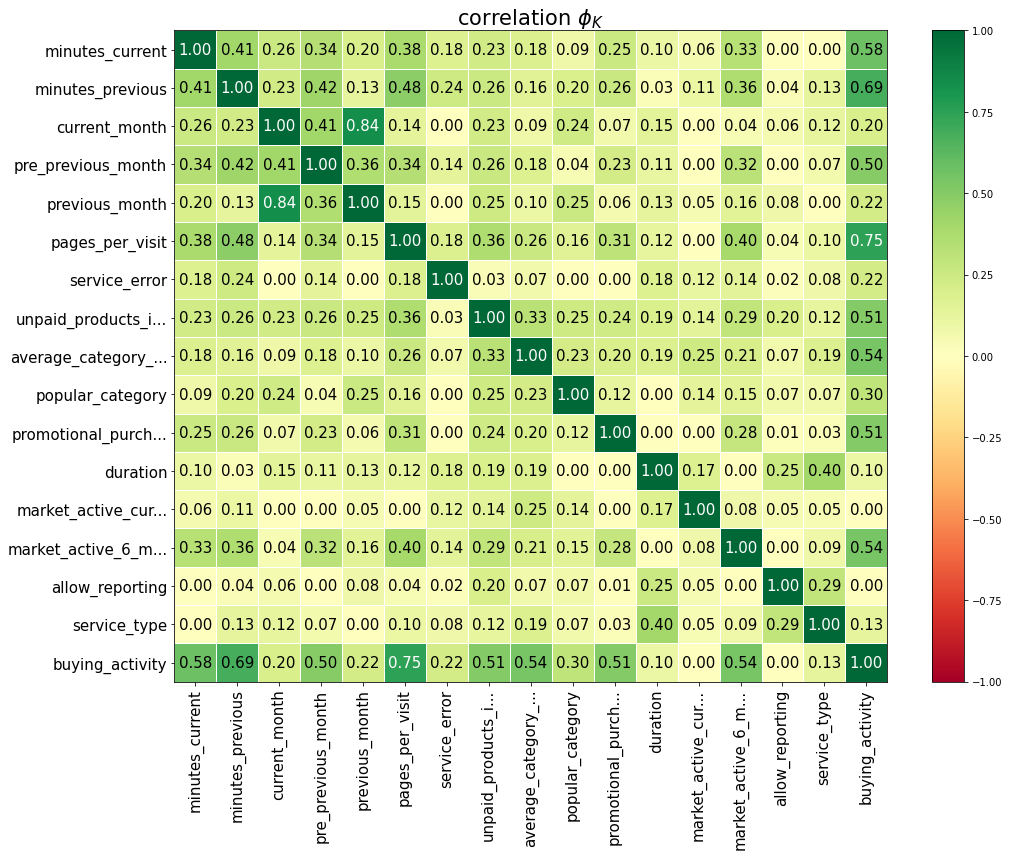

In [79]:
# список интервальных признаков
interval_cols = ['market_active_6_month', 'promotional_purchases', 'current_month',\
'duration','service_error','pages_per_visit','unpaid_products_items_quarter',\
'previous_month','pre_previous_month','average_category_view_per_visit',\
'minutes_current', 'minutes_previous']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = market_pivot.iloc[:,1:].phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    title=r"correlation $\phi_K$", 
    fontsize_factor=1.5, 
    figsize=(15, 12)
)


Данные тепловой карты перекликаются с проведенным исследовательским анализом данных. Это видно по последней строке, где представлены коэф. корелляции покупательской активности в зависимости от других признаков.

Покупательская активность наиболее кореллирует с pages_per_visit - 0.75, а также хорошо кореллирует с другими катерогиями, связанными с активностью клиентов на сайте. 

Мультикоринеарности не наблюдается - максимальное значение коэф. корреляции 0.84 (меньше 0.9) 

### Дисбаланс классов </b></font><br>

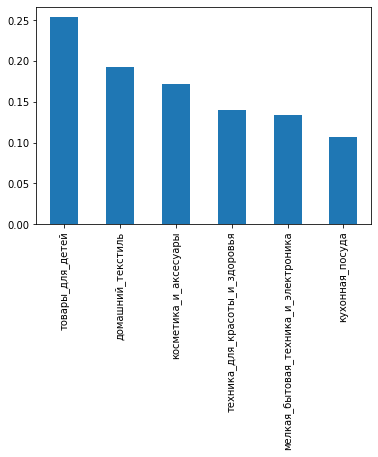

In [80]:
market_pivot.popular_category.value_counts(normalize=True).plot(kind='bar'); 

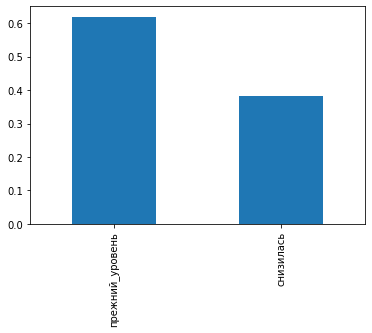

In [81]:
market_pivot.buying_activity.value_counts(normalize=True).plot(kind='bar'); 

У "buying_activity" дисбалланс классов приемлимый. В дальнейшем детальному рассмотрению подлежит "buying_activity", поэтому дисбалланс классов испрапвлять не будем.

**Для построения моделей создадим столбец 'buying_activity_bool':**

- "прежний уровень": 0 
- "снизилась" : 1

In [82]:
#market_pivot['buying_activity_bool'] = market_pivot['buying_activity'].\
#replace({'прежний_уровень' : 0, 'снизилась' : 1})

In [84]:
market_pivot.head()

id buying_activity service_type allow_reporting  market_active_6_month  \
1  215349       снизилась      премиум              да                    4.4   
2  215350       снизилась     стандарт             нет                    4.9   
3  215351       снизилась     стандарт              да                    3.2   
4  215352       снизилась     стандарт             нет                    5.1   
5  215353       снизилась     стандарт              да                    3.3   

   market_active_current_month  duration  promotional_purchases  \
1                            4       819                   0.75   
2                            3       539                   0.14   
3                            5       896                   0.99   
4                            3      1064                   0.94   
5                            4       762                   0.26   

    popular_category  average_category_view_per_visit  \
1   товары_для_детей                                4   
2  домашний_текстиль                                5   
3   товары_для_детей                                5   
4   товары_для_детей                                3   
5  домашний_текстиль                                4   

   unpaid_products_items_quarter  service_error  pages_per_visit  \
1                              4              2                5   
2                              2              1                5   
3                              0              6                4   
4                              2              3                2   
5                              1              1                4   

   previous_month  pre_previous_month  current_month  minutes_previous  \
1          5216.0              4472.0         4971.6                12   
2          5457.5              4826.0         5058.4                 8   
3          6158.0              4793.0         6610.4                11   
4          5807.5              4594.0         5872.5                 8   
5          4738.5              5124.0         5388.5                10   

   minutes_current  
1               10  
2               13  
3               13  
4               11  
5               10

## Шаг 6. Использование пайплайнов

In [85]:
market_pivot.columns

Index(['id', 'buying_activity', 'service_type', 'allow_reporting',
       'market_active_6_month', 'market_active_current_month', 'duration',
       'promotional_purchases', 'popular_category',
       'average_category_view_per_visit', 'unpaid_products_items_quarter',
       'service_error', 'pages_per_visit', 'previous_month',
       'pre_previous_month', 'current_month', 'minutes_previous',
       'minutes_current'],
      dtype='object')

In [88]:
RANDOM_STATE = 76
TEST_SIZE = 0.25



X_train, X_test, y_train, y_test = train_test_split(
    market_pivot.drop(['buying_activity','id'], axis=1),
    market_pivot['buying_activity'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_pivot['buying_activity'])


# создаём списки с названиями признаков
ohe_columns = ['allow_reporting','popular_category']
ord_columns = ['service_type']
num_columns = ['market_active_6_month', 'market_active_current_month', 'duration',
'promotional_purchases','average_category_view_per_visit', 'unpaid_products_items_quarter',
'service_error', 'pages_per_visit', 'current_month', 'previous_month',
'pre_previous_month', 'minutes_current', 'minutes_previous']


# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт','премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        #'models__min_samples_split': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l3'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {   'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'models': [SVC(random_state = RANDOM_STATE, probability= True)],
        'models__kernel': ['linear', 'rbf', 'sigmoid','poly']   
    }    
    
]
    


# сделаем перебор гиперпаратеров через RandomizedSearchCV
start_time = time.time()
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)


y_test_pred = randomized_search.predict(X_test)
y_test_pred_prob = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_prob[:,1])}')
print('Время исполнения кода:', time.time() - start_time)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['allow_reporting',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                               

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/conda/lib/python3

**Посчитаем по вероятностям классов метрику ROC-AUC***

— это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного.

In [89]:
#roc_auc считаем по вероятностям классов.

#print('Площадь ROC-кривой:', roc_auc_score(y_test, y_test_pred_prob[:, 1]))

In [90]:
probabilities = randomized_search.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9280645161290323


У нас значение 0.92 - хороший результат.

(Максимальное значение площади равно 1, это значение ROC-AUC идеальной модели, которая совсем не ошибается.)

**Строим график ROC-кривой - зависимость FPR от TPR.**

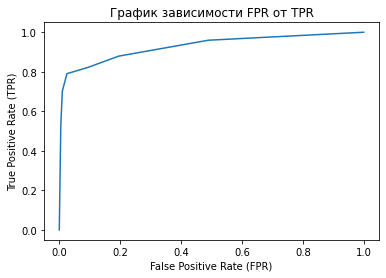

In [91]:
## рассчитайте значения FPR и TRP
y_test3 = y_test.replace({'прежний_уровень' : 0, 'снизилась' : 1})

fpr, tpr, threshold = roc_curve(y_test3, y_test_pred_prob[:, 1])

# постройте график зависимости FPR от TPR
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

**True Positive Rate, TPR** — доля положительных объектов, правильно предсказанных положительными, или доля верно классифицированных объектов класса 1.

**False Positive Rate, FPR** — доля отрицательных объектов, неверно предсказанных положительными, или доля неверно классифицированных объектов класса 0

Форма кривой хорошая, с резким переломом в районе 0.8.

При TRP в районе 0.8 начинает расти FPR.Это и есть компромисный порог.

### Вывод

Лучшая модель:

LogisticRegression(C=1, penalty='l1', random_state=76,
                                    solver='liblinear'))

Метрика лучшей модели на тренировочной выборке: 0.9009226788772244

Метрика ROC-AUC на тестовой выборке: 0.8682258064516128
Время исполнения кода: 2.343949317932129



Компромисный порог (из анализа ROC-кривой) - 0.8

## Шаг 7. Анализ важности признаков

В исследовательском анализе данных степень важности признаков мы определяли визуальным просмотром графиков.
Сейчас оценим важность признаков на основании разработанной в п.6 прогнозной модели.

In [92]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)


explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2)


#shap_values_pos = shap_values[:, :, 1]


display(shap.plots.bar(shap_values, max_display=23))
shap.plots.beeswarm(shap_values, max_display=23) 

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(n_neighbors=6)

График показывает важность признака "мелкая бытовая техника и электроника", что перекликается с [исследовательским анализом данных.](#1243) <a id='1244'></a>


<font color='blue'><b> Вывод: </b></font><br>
Падение важности признаков 'popular_category' в построенной модели полностью соответствует исследовательскому анализу данных. Остальные признаки также перекликаются с исследовательским анализом данных.



Данный вывод свидетельствует в пользу корректности выбранной модели.

## Шаг 8. Сегментация покупателей

<font color='green'><b> Анализ группы клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью: </b></font><br>

В рамках задачи по разработке модели, предсказывающей вероятность снижения покупательской активности, этот сегмент, на мой взгляд, наиболее важен.

### Выделим датасет risk_group с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью на основании прогнозных меток

In [93]:
#На основании построенной модели промаркируем прогнозными метками весь датасет
X = market_pivot.drop(['buying_activity','id'], axis=1)
y = market_pivot['buying_activity']


y_prob_all = randomized_search.predict_proba(X)
print ('Метрика ROC-AUC на всем датасете:', roc_auc_score(y, y_prob_all[:,1])) 

Метрика ROC-AUC на всем датасете: 0.947738194998334


In [94]:
# Добавим в датасет market_pivot прогнозные метки классов
market_pivot['buying_activity_predict'] = y_prob_all[:,1]

Добавил в market_pivot прибыль из датасета money:

In [95]:
market_pivot = market_pivot.merge(money, on='id')

In [96]:
market_pivot.head()

id buying_activity service_type allow_reporting  market_active_6_month  \
0  215349       снизилась      премиум              да                    4.4   
1  215350       снизилась     стандарт             нет                    4.9   
2  215351       снизилась     стандарт              да                    3.2   
3  215352       снизилась     стандарт             нет                    5.1   
4  215353       снизилась     стандарт              да                    3.3   

   market_active_current_month  duration  promotional_purchases  \
0                            4       819                   0.75   
1                            3       539                   0.14   
2                            5       896                   0.99   
3                            3      1064                   0.94   
4                            4       762                   0.26   

    popular_category  average_category_view_per_visit  \
0   товары_для_детей                                4   
1  домашний_текстиль                                5   
2   товары_для_детей                                5   
3   товары_для_детей                                3   
4  домашний_текстиль                                4   

   unpaid_products_items_quarter  service_error  pages_per_visit  \
0                              4              2                5   
1                              2              1                5   
2                              0              6                4   
3                              2              3                2   
4                              1              1                4   

   previous_month  pre_previous_month  current_month  minutes_previous  \
0          5216.0              4472.0         4971.6                12   
1          5457.5              4826.0         5058.4                 8   
2          6158.0              4793.0         6610.4                11   
3          5807.5              4594.0         5872.5                 8   
4          4738.5              5124.0         5388.5                10   

   minutes_current  buying_activity_predict  profit  
0               10                 1.000000    4.16  
1               13                 0.500000    3.13  
2               13                 1.000000    4.87  
3               11                 1.000000    4.21  
4               10                 0.833333    3.95

**Выведем гисторгамму распределения вероятностей, с которой предсказана покупательная активность.**

<font color='red'><b>0 - активность на прежнем уровне, 1 - снизилась</b></font><br> 

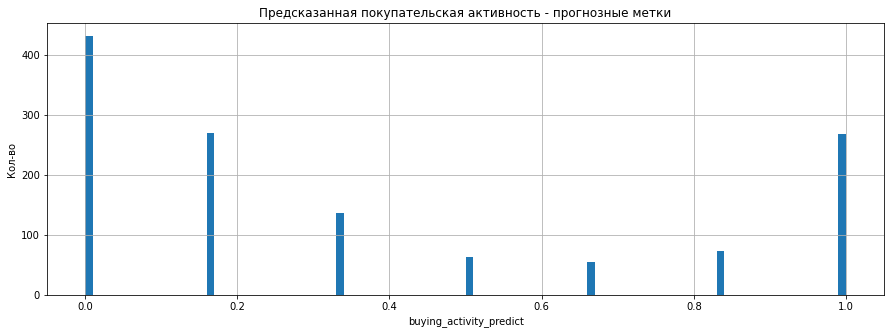

In [97]:
market_pivot['buying_activity_predict'].hist(bins = 100,range = (0,1),grid = True,figsize = (15,5))
plt.title('Предсказанная покупательская активность - прогнозные метки')
plt.xlabel('buying_activity_predict')
plt.ylabel('Кол-во');

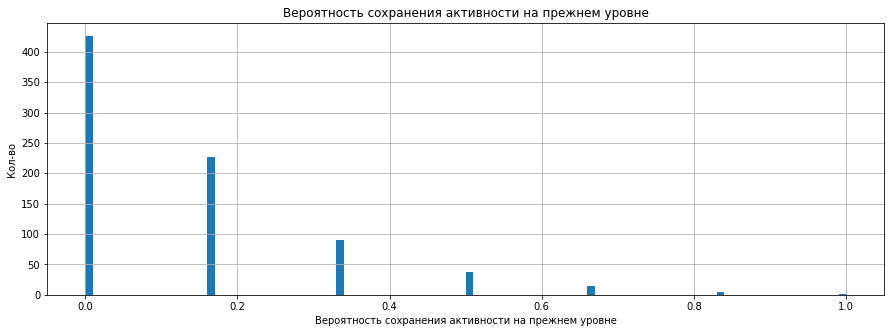

In [98]:
#Левая часть - вероятность сохранения активности на прежнем уровне
market_pivot.loc[market_pivot['buying_activity'] == 'прежний_уровень']['buying_activity_predict'].hist(bins = 100,range = (0,1),grid = True,figsize = (15,5))
plt.title('Вероятность сохранения активности на прежнем уровне')
plt.xlabel('Вероятность сохранения активности на прежнем уровне')
plt.ylabel('Кол-во');

На графике в левой части (левее 0.5) расположены клиенты, которые скорее сохранили прежний уровень активности, чем снизили.Соответственно в правой части (правее 0.5) - покупатели, которые скорее снизили уровень активности, чем остались на прежнем уровне.
Нас интересуют покупатели, расположенные в левой части, а точнее та их часть, которая расположена в пограничной области.Это клиенты, которые уже снизили активность, но не настолько, чтобы быть классифицированными как "снизили".Это прямые кандидаты на дальнейшее снижение активности.


**Выберем покупателей, которые скорее сохранили активность, чем снизили в пределах вероятностей от 0.2 до 0.8 - так называемая группа риска risk_group. Нижняя граница 0.2 выбрана интуитивно, верхняя 0.8 - порог по ROC-кривой.**

In [99]:
risk_group = market_pivot.loc[(market_pivot['buying_activity'] == 'прежний_уровень')\
& (market_pivot['buying_activity_predict'] < 0.8)\
& (market_pivot['buying_activity_predict'] > 0.2)\
& (market_pivot['profit'] > 4.0)]

In [100]:
risk_group.head()

id  buying_activity service_type allow_reporting  \
396  215748  прежний_уровень     стандарт             нет   
400  215752  прежний_уровень     стандарт             нет   
424  215776  прежний_уровень     стандарт             нет   
501  215853  прежний_уровень      премиум              да   
528  215880  прежний_уровень      премиум              да   

     market_active_6_month  market_active_current_month  duration  \
396                    4.3                            4       534   
400                    4.0                            4       475   
424                    4.4                            4       467   
501                    3.3                            4       890   
528                    4.3                            5       897   

     promotional_purchases                      popular_category  \
396                   0.18                       кухонная_посуда   
400                   0.30  мелкая_бытовая_техника_и_электроника   
424                   0.15        техника_для_красоты_и_здоровья   
501                   0.11                 косметика_и_аксесуары   
528                   0.30  мелкая_бытовая_техника_и_электроника   

     average_category_view_per_visit  unpaid_products_items_quarter  \
396                                3                              1   
400                                3                              3   
424                                2                              2   
501                                4                              1   
528                                4                              4   

     service_error  pages_per_visit  previous_month  pre_previous_month  \
396              4               10          5083.0              4552.0   
400              7                7          5188.5              4635.0   
424              2               10          4388.0              4712.0   
501              3               11          5204.0              4865.0   
528              2               11          4228.0              4555.0   

     current_month  minutes_previous  minutes_current  \
396         5673.2                13               13   
400         5798.2                13                8   
424         4798.8                15               11   
501         5627.8                 7               14   
528         4074.6                15               11   

     buying_activity_predict  profit  
396                 0.500000    4.11  
400                 0.500000    4.06  
424                 0.333333    4.06  
501                 0.500000    4.31  
528                 0.333333    4.23

In [101]:
risk_group.describe(include='all').T

count unique                    top freq  \
id                               69.0    NaN                    NaN  NaN   
buying_activity                    69      1        прежний_уровень   69   
service_type                       69      2               стандарт   47   
allow_reporting                    69      2                     да   50   
market_active_6_month            69.0    NaN                    NaN  NaN   
market_active_current_month      69.0    NaN                    NaN  NaN   
duration                         69.0    NaN                    NaN  NaN   
promotional_purchases            69.0    NaN                    NaN  NaN   
popular_category                   69      6  косметика_и_аксесуары   18   
average_category_view_per_visit  69.0    NaN                    NaN  NaN   
unpaid_products_items_quarter    69.0    NaN                    NaN  NaN   
service_error                    69.0    NaN                    NaN  NaN   
pages_per_visit                  69.0    NaN                    NaN  NaN   
previous_month                   69.0    NaN                    NaN  NaN   
pre_previous_month               69.0    NaN                    NaN  NaN   
current_month                    69.0    NaN                    NaN  NaN   
minutes_previous                 69.0    NaN                    NaN  NaN   
minutes_current                  69.0    NaN                    NaN  NaN   
buying_activity_predict          69.0    NaN                    NaN  NaN   
profit                           69.0    NaN                    NaN  NaN   

                                          mean         std       min  \
id                               216303.913043  222.369707  215748.0   
buying_activity                            NaN         NaN       NaN   
service_type                               NaN         NaN       NaN   
allow_reporting                            NaN         NaN       NaN   
market_active_6_month                  4.44058    0.829479       2.6   
market_active_current_month           4.072464    0.692796       3.0   
duration                            646.898551  258.552256     165.0   
promotional_purchases                 0.305072    0.257954      0.11   
popular_category                           NaN         NaN       NaN   
average_category_view_per_visit       2.811594    1.115075       1.0   
unpaid_products_items_quarter         2.275362    1.523194       0.0   
service_error                         3.942029    2.208833       0.0   
pages_per_visit                       8.898551     3.55687       3.0   
previous_month                     4792.514493  629.752595    3568.0   
pre_previous_month                 4901.637681  342.871738    4341.0   
current_month                      5057.450725  725.506943    3588.0   
minutes_previous                     14.405797    3.414152       7.0   
minutes_current                      13.956522    3.983181       5.0   
buying_activity_predict               0.415459    0.119992  0.333333   
profit                                4.757101    0.661587      4.01   

                                      25%       50%       75%       max  
id                               216191.0  216330.0  216449.0  216646.0  
buying_activity                       NaN       NaN       NaN       NaN  
service_type                          NaN       NaN       NaN       NaN  
allow_reporting                       NaN       NaN       NaN       NaN  
market_active_6_month                 4.0       4.3       5.1       6.3  
market_active_current_month           4.0       4.0       5.0       5.0  
duration                            453.0     663.0     890.0    1041.0  
promotional_purchases                0.16      0.23      0.28      0.99  
popular_category                      NaN       NaN       NaN       NaN  
average_category_view_per_visit       2.0       3.0       4.0       6.0  
unpaid_products_items_quarter         1.0       2.0       3.0       7.0  
service_error                     

В группе риска 109 покупателей - это примерно 8 % от общего числа клиентов 

<font color='blue'><b>Для того, чтобы понять тенденции  в risk_group, необходимо оценить отличия признаков в датасетах market_pivot и группы риска risk_group. </b></font><br>


### Оценим изменения значений признаков общего датасета market_pivot и группы риска risk_group

In [102]:
#Создадим функцию
# Влияние признаков на снижение покупательской активности
def comparison_сategory (x):
    tabl = pd.concat([market_pivot[x].value_counts(),\
    risk_group[x].value_counts()], axis=1)

    tabl.columns= ['Кол-во в стабильной группе', 'Кол-во в группе риска']
    
    tabl['(%) от общего кол-ва market_pivot'] = round(((tabl['Кол-во в стабильной группе']\
    / market_pivot['popular_category'].count()))*100,2)
    
    tabl['(%) от общего кол-ва risk_group'] = round(((tabl['Кол-во в группе риска']\
    / risk_group['popular_category'].count()))*100,2)    
    
     
    tabl['Разница в  (%)'] = tabl['(%) от общего кол-ва risk_group']\
    - tabl['(%) от общего кол-ва market_pivot']
    
    
    tabl['На сколько (%) изменились (%)risk_group от (%)market_pivot'] = ((tabl['(%) от общего кол-ва risk_group']\
    - tabl['(%) от общего кол-ва market_pivot'])/tabl['(%) от общего кол-ва market_pivot']*100).round(2)
    
    return tabl

#### <font color='green'><b>в разрезе popular_category:</b></font><br>

In [103]:
comparison_сategory ('popular_category')

Кол-во в стабильной группе  \
товары_для_детей                                             329   
домашний_текстиль                                            250   
косметика_и_аксесуары                                        223   
техника_для_красоты_и_здоровья                               182   
мелкая_бытовая_техника_и_электроника                         174   
кухонная_посуда                                              138   

                                      Кол-во в группе риска  \
товары_для_детей                                         14   
домашний_текстиль                                         8   
косметика_и_аксесуары                                    18   
техника_для_красоты_и_здоровья                           14   
мелкая_бытовая_техника_и_электроника                      6   
кухонная_посуда                                           9   

                                      (%) от общего кол-ва market_pivot  \
товары_для_детей                                                  25.39   
домашний_текстиль                                                 19.29   
косметика_и_аксесуары                                             17.21   
техника_для_красоты_и_здоровья                                    14.04   
мелкая_бытовая_техника_и_электроника                              13.43   
кухонная_посуда                                                   10.65   

                                      (%) от общего кол-ва risk_group  \
товары_для_детей                                                20.29   
домашний_текстиль                                               11.59   
косметика_и_аксесуары                                           26.09   
техника_для_красоты_и_здоровья                                  20.29   
мелкая_бытовая_техника_и_электроника                             8.70   
кухонная_посуда                                                 13.04   

                                      Разница в  (%)  \
товары_для_детей                               -5.10   
домашний_текстиль                              -7.70   
косметика_и_аксесуары                           8.88   
техника_для_красоты_и_здоровья                  6.25   
мелкая_бытовая_техника_и_электроника           -4.73   
кухонная_посуда                                 2.39   

                                      На сколько (%) изменились (%)risk_group от (%)market_pivot  
товары_для_детей                                                                 -20.09           
домашний_текстиль                                                                -39.92           
косметика_и_аксесуары                                                             51.60           
техника_для_красоты_и_здоровья                                                    44.52           
мелкая_бытовая_техника_и_электроника                                             -35.22           
кухонная_посуда                                                                   22.44

Категория **товары_для_детей** - лидирует,при этом  отнотительная доля в датасете **risk_group** возросла.
Присутствует падение по категории **мелкая _бытовая_техника_ и _электроника** - последнее место и падение в процентах от общего кол-ва в 2.5 раза.

#### <font color='green'><b>в разрезе service_type:</b></font><br>

In [104]:
comparison_сategory ('service_type')

Кол-во в стабильной группе  Кол-во в группе риска  \
стандарт                         922                     47   
премиум                          374                     22   

          (%) от общего кол-ва market_pivot  (%) от общего кол-ва risk_group  \
стандарт                              71.14                            68.12   
премиум                               28.86                            31.88   

          Разница в  (%)  \
стандарт           -3.02   
премиум             3.02   

          На сколько (%) изменились (%)risk_group от (%)market_pivot  
стандарт                                              -4.25           
премиум                                               10.46

Пропорции практически не изменились.

#### <font color='green'><b>в разрезе allow_reporting:</b></font><br>

In [105]:
comparison_сategory ('allow_reporting')

Кол-во в стабильной группе  Кол-во в группе риска  \
да                          959                     50   
нет                         337                     19   

     (%) от общего кол-ва market_pivot  (%) от общего кол-ва risk_group  \
да                                74.0                            72.46   
нет                               26.0                            27.54   

     Разница в  (%)  \
да            -1.54   
нет            1.54   

     На сколько (%) изменились (%)risk_group от (%)market_pivot  
да                                               -2.08           
нет                                               5.92

Пропорции практически не изменились.

#### <font color='green'><b>Определим разницу в выручке между периодами с группировкой по категориям:</b></font><br>

In [106]:
def revenue_pop_cat(dat, per_iod, title, xlabel ,ylabel):
    column_s = [] # список столбцов сводной таблицы
    titl_e = []    # список названий столбцов сводной таблицы
    period = per_iod   
    for i in period:  
        column_s.append(dat.groupby('popular_category')[i].median())
        titl_e.append(i)
        pivot_4 = pd.concat(column_s,axis=1)  # Создаем сводную таблицу
        pivot_4.columns = [titl_e]
    pivot_4.T.plot(grid = True,figsize = (12,6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);    


**Строим график Выручки по периодам в разрезе популярных категорий market_pivot и risk_group**

[к пункту 2.10](#7777)
<a id='7778'></a>

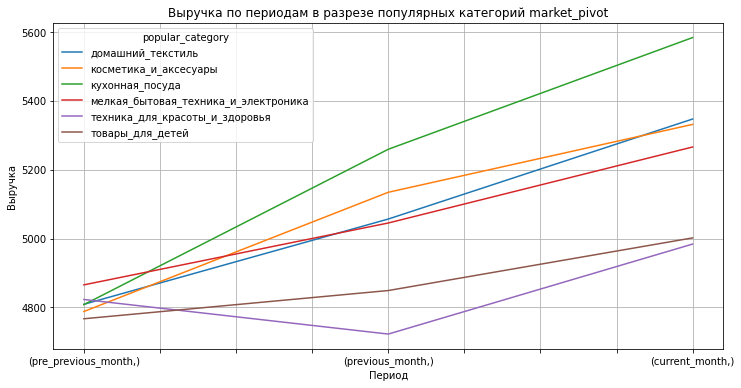

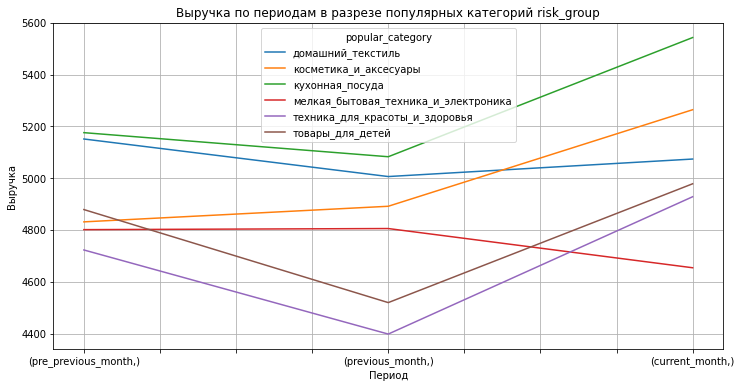

In [107]:
#Строим график Выручка по периодам в разрезе популярных категорий market_pivot
revenue_pop_cat(
    market_pivot,
    ['pre_previous_month', 'previous_month', 'current_month'],
    'Выручка по периодам в разрезе популярных категорий market_pivot',
    'Период',
    'Выручка'
)

#Строим график Выручка по периодам в разрезе популярных категорий risk_group
revenue_pop_cat(
    risk_group,
    ['pre_previous_month', 'previous_month', 'current_month'],
    'Выручка по периодам в разрезе популярных категорий risk_group',
    'Период',
    'Выручка'
)


Общая тенденция в датасетах схожая: рост выручки в динамике.В обоих случаях наблюдается просадка по выручке в предыдущем месяце в категориях **техника_для_красоты _ и _здоровья** 

и       **товары_для_детей**.
 
Причем в **risk_group** просадка по **товары_для_детей** значительно больше, чем в общем датасете.

А  в  **мелкая _бытовая_техника_ и_электроника** наблюдается даже слегка нелинейный рост выручки - это при значительном уменьшении доли покупок в данной категории - **ПОКУПАЮТ БОЛЕЕ ДОРОГУЮ ТЕХНИКУ**, но мало.


#### <font color='green'><b>Определим разницу во времени, которое провел покупатель на сайте в течение периода в разрезе популярных категорий:</b></font><br>

**Строим график времени, которое провел покупатель на сайте в течение периода в разрезе популярных категорий market_pivot и risk_group**

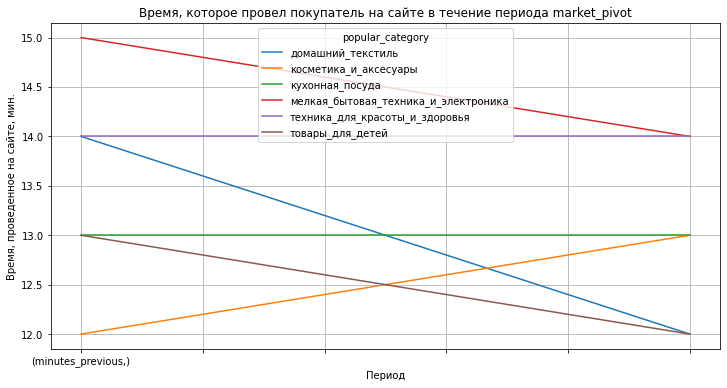

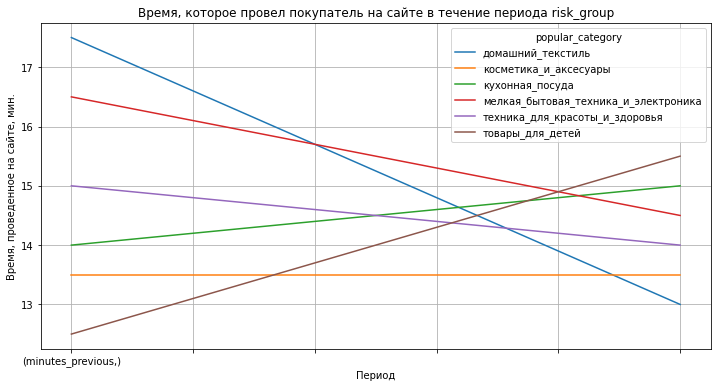

In [108]:
#Строим график Время, которое провел покупатель на сайте в течение периода market_pivot
revenue_pop_cat(
    market_pivot,
    ['minutes_previous','minutes_current'],
    'Время, которое провел покупатель на сайте в течение периода market_pivot',
    'Период',
    'Время, проведенное на сайте, мин.'
)

#Строим график Время, которое провел покупатель на сайте в течение периода risk_group
revenue_pop_cat(
    risk_group,
    ['minutes_previous','minutes_current'],
    'Время, которое провел покупатель на сайте в течение периода risk_group',
    'Период',
    'Время, проведенное на сайте, мин.'
)

**Общая тенденция**: 
Возрастание времени нахождения на сайте  покупателей с любимой категорией  **косметика_ и _аксесуары**,у остальных уменьшается либо на прежнем уровне.


В **risk_group** по сравнению с общим датасетом наблюдается повышенный интерес  покупателей с любимой категорией  **техника_ для _красоты _ и _здоровья**.

#### <font color='green'><b>Оценка прибыльности по популярным категориям товара:</b></font><br>

In [109]:
market_pivot.groupby('popular_category')['profit'].median().sort_values(ascending = False)

popular_category
косметика_и_аксесуары                   4.150
кухонная_посуда                         4.105
товары_для_детей                        4.080
домашний_текстиль                       4.020
мелкая_бытовая_техника_и_электроника    3.990
техника_для_красоты_и_здоровья          3.770
Name: profit, dtype: float64

In [110]:
risk_group.groupby('popular_category')['profit'].median().sort_values(ascending = False)

popular_category
домашний_текстиль                       5.510
кухонная_посуда                         4.920
товары_для_детей                        4.645
косметика_и_аксесуары                   4.635
техника_для_красоты_и_здоровья          4.355
мелкая_бытовая_техника_и_электроника    4.270
Name: profit, dtype: float64

Наиболее прибыльная  категория **косметика_ и _аксесуары**, наименее -  **техника_ для _красоты_ и _здоровья**           и                   **мелкая_ бытовая _техника_ и _электроника** .Скорее всего техника сама по себе дорогая, но прибыль в ней заложена меньше, чем в других категориях.

В **risk_group** прибыльность примерно на одном уровне.

#### <font color='green'><b>Активность покупателей   market_active_6_month и
market_active_current_month   по периодам в разрезе популярных категорий товара</b></font><br>

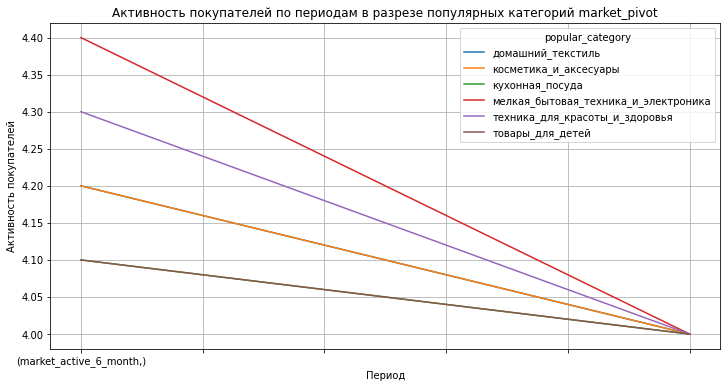

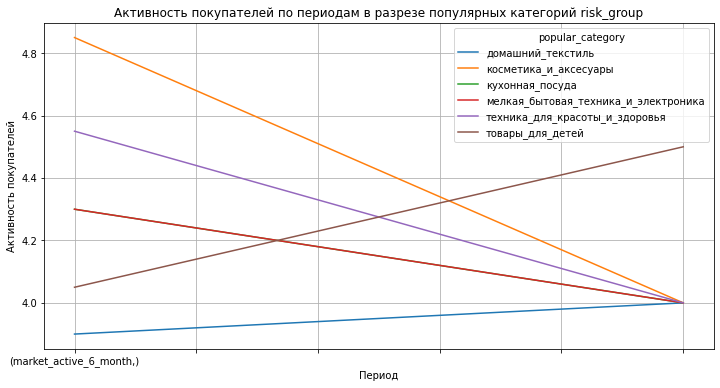

In [111]:
#Строим график Активность покупателей по периодам в разрезе популярных категорий market_pivot
revenue_pop_cat(
    market_pivot,
    ['market_active_6_month','market_active_current_month'],
    'Активность покупателей по периодам в разрезе популярных категорий market_pivot',
    'Период',
    'Активность покупателей'
)

#Строим график Активность покупателей по периодам в разрезе популярных категорий risk_group
revenue_pop_cat(
    risk_group,
    ['market_active_6_month','market_active_current_month'],
    'Активность покупателей по периодам в разрезе популярных категорий risk_group',
    'Период',
    'Активность покупателей'
)

Активность снижается схожим образом в обоих датасетах.

#### <font color='green'><b>Неоплаченные товары в корзине unpaid_products_items_quarter разрезе популярных категорий товара</b></font><br>

In [112]:
risk_group.groupby('popular_category')['unpaid_products_items_quarter'].median().sort_values(ascending = False)

popular_category
домашний_текстиль                       3.0
мелкая_бытовая_техника_и_электроника    3.0
товары_для_детей                        2.5
косметика_и_аксесуары                   2.0
техника_для_красоты_и_здоровья          2.0
кухонная_посуда                         1.0
Name: unpaid_products_items_quarter, dtype: float64

In [113]:
market_pivot.groupby('popular_category')['unpaid_products_items_quarter'].median().sort_values(ascending = False)

popular_category
домашний_текстиль                       3
кухонная_посуда                         3
товары_для_детей                        3
косметика_и_аксесуары                   2
мелкая_бытовая_техника_и_электроника    2
техника_для_красоты_и_здоровья          2
Name: unpaid_products_items_quarter, dtype: int64

Картина схожая, без аномалий.



#### <font color='green'><b>Доля акционных покупок promotional_purchases разрезе популярных категорий товара</b></font><br>

In [114]:
market_pivot.groupby('popular_category')['promotional_purchases'].median().sort_values(ascending = False)

popular_category
кухонная_посуда                         0.270
косметика_и_аксесуары                   0.250
товары_для_детей                        0.250
техника_для_красоты_и_здоровья          0.240
домашний_текстиль                       0.230
мелкая_бытовая_техника_и_электроника    0.225
Name: promotional_purchases, dtype: float64

In [115]:
risk_group.groupby('popular_category')['promotional_purchases'].median().sort_values(ascending = False)

popular_category
мелкая_бытовая_техника_и_электроника    0.275
кухонная_посуда                         0.260
косметика_и_аксесуары                   0.210
техника_для_красоты_и_здоровья          0.200
товары_для_детей                        0.195
домашний_текстиль                       0.190
Name: promotional_purchases, dtype: float64

Тенденция схожая, отметим повышенную долю акционных покупок у групп **мелкая _бытовая_техника_ и _электроника**    
и **техника_для_красоты_ и _здоровья**.          
Также наблюдается уменьшение акционных покупок группы **товары_ для _детей**       
в    **risk_group**.                   

<font color='blue'><b>Вывод по сравнению датасетов: </b></font><br>

По сравнению с  **market_pivot** у **risk_group**:

- **товары для детей** покупают больше (по кол-ву покупок), но есть падение выручки в предыдущем месяце по этой категории.Скорее всего был переход на более дешевые товары ;
- **ПОВЫШЕННЫЙ ИНТЕРЕС** (время проведения на сайте) к категории **техника_ для _красоты_ и _здоровья**, при просадке выручки  и пониженном кол-ве покупок у категории;
- пониженная доля акционных покупок у категории **товары для детей**;
- высокая доля акционных покупок у категорий **мелкая _бытовая_техника_ и_электроника** и **техника_ для _красоты_ и _здоровья**
- у категории **мелкая _бытовая_техника_ и_электроника** при значительном уменьшении  доли покупок наблюдается повышенный рост выручки.То есть  **ПОКУПАЮТ БОЛЕЕ ДОРОГУЮ ТЕХНИКУ**.


**Резюмируем:**

- **техника_ для _красоты_ и _здоровья** - повышенный интерес, но мало покупают, при этом охотно покупают по акции.
- **товары для детей** - при общем падении интереса покупают много,но мало по акциям.Есть склонность покупать более дешевый товар, но товар по акциям не устраивает.
- **мелкая _бытовая_техника_ и_электроника** - покупают мало, при этом предпочитают более дорогую технику.


#### Рассмортим более подробно долю акционных покупок promotional_purchases  на основе прогнозных меток buying_activity_predict:

In [116]:
# profit
fig = px.scatter(market_pivot, x="buying_activity_predict", y="promotional_purchases", color="profit")
fig.show()

In [117]:
# pre_previous_month
fig = px.scatter(market_pivot, x="buying_activity_predict", y="promotional_purchases", color="pre_previous_month")
fig.show()

In [118]:
# previous_month
fig = px.scatter(market_pivot, x="buying_activity_predict", y="promotional_purchases", color="previous_month")
fig.show()

In [119]:
# current_month
fig = px.scatter(market_pivot, x="buying_activity_predict", y="promotional_purchases", color="current_month")
fig.show()

In [120]:
# pages_per_visit
fig = px.scatter(market_pivot, x="buying_activity_predict", y="promotional_purchases", color="pages_per_visit")
fig.show()

[Скаттеры на основании прогнозных меток полностью подтверждают сделанные ранее выводы.](#8745)
<a id='8744'></a>
Распределение выручки current_month, previous_month  происходит более менее равномерно по всему графику снижения активности покупателей акционных товаров.График с pre_previous_month - наблюдается по мере снижения активности покупателей также снижение выручки.[См. График   Выручка по периодам в разрезе популярных категорий](#7778)
<a id='7777'></a> На нем снижение выручки происходит благодаря товарам для детей для основного датасета, и благодаря товарам для детей и технике для красоты и здоровья для датасета risk_group.

## Шаг 9. Общий вывод

В ходе выполнения проекта были проведены следующие мероприятия:

**1. Загружено 4 файла:**

1. market_file - Таблица с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. market_time - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. market_money - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
4. money - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**2. Выполнена предобработка данных:**

1. Категориальные данные приведены к нижнему регистру, пробелы заменены подчеркиванием.
2. Названия столбцов переименованы для удобства дальнейшей работы.
3. Пропусков данных в датафреймах и дубликатов строк не обнаружено.
4. Устранены опечатки в категориальных данных (неявные дубликаты)

**3. Проведен исследовательский анализ данных:**

**КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ**

- **market_active_6_month** - Cреднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев:

Распределение близкое к нормальному. Средняя покупательская активность меньше 3 операций выделяется из распределения, что подтверждается боксплотом. Пока удалять эти выбросы не будем, так как они отражают клиентов с малой активностью.

- **market_active_current_month** — количество маркетинговых коммуникаций в текущем месяце:

Несмотря на малую вариацию значений (3, 4, 5 операций), "нормальность" прослеживается. Также отсутствуют аномально малые значения мельше 3, что подтверждает правильность намерения отсечь клиентов с покупательной активностью менее 3 месяцев.

- **duration** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте:

Распределение близкое к нормальному,хотя колокол растянут.Несмотря на то, что пик колокола прослеживается, в распределении присутствует составляющая равномерного распределения. Медианное значение duration почти равно среднему, аномальных выбросов не наблюдается.
**Отметим, последний пользователь зарегистрировался на сайте 110 дней назад - это более 3-х месяцев.**

- **promotional_purchases** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев:

Основная группа значений (0 - 0.5) близка к нормальному распределению.Медианное значение 0.24, наблюдается выброс значений  в интервале 0.85 - 1.0 покупки за 6 мес.
Аномальных покупок по акциям 165.Это 12.6% от общего числа клиентов.Ощутимая доля, поэтому не стали удалять эти данные.

- **average_category_view_per_visit** — Средний_просмотр_категорий_за_визит в течение последнего месяца.

Нормальное распределение с небольшим смещением влево.Ближе к распределению Пуассона.Выбросов нет.

- **unpaid_products_items_quarter** — общее число неоплаченных товаров в корзине за последние 3 месяца.

Похоже на распределение Пуассона. Наблюдаются аномальные значения более 8 неоплаченных товаров в корзине.
Таких значений 14.Данные оставили, так как они информативны.

- **service_error** — число сбоев, которые коснулись покупателя во время посещения сайта.

Нормальное распределение без выбросов.

- **pages_per_visit** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца:

Нормальное распределение с небольшим смещением влево, если не считать аномалии в районе 4 - 6 страниц просмотра. Скорее всего это некое комфортное число просматриваемых страниц. Отметим это как особенность психологии пользователей.

- **revenue** — сумма выручки за период:

Типичное нормальное распределение.Медианное значение выручки составляет порядка 5000 рублей за период.Присуствует аномальнрое значение 106862 рубля.
Клиент id = 215380 аномальный. Было решено удалить его из датафрейма.

- **распределение выручки revenue по месяцам:**

- Выручка за последние 3 месяца увеличивается:медианные значения 4809, 5005, 5180.При этом наблюдается последовательное (от месяца к месяцу) увеличение разброса значений выручки.То есть часть пользователей стала покупать товаров на меньшую сумму и большую суммы.Определенно меняется поведение покупателей.Теряется стабильность спроса.


- **minutes** — значение времени, проведённого на сайте, в минутах:

Нормальное распределение.Медианное время, проведенное на сайте в районе 13 минут.

-**Распределение времени minutes, проведенного на сайтах по месяцам:**

- Среднее время, проведенное на сайте, практически не изменилось.Однако поменялась форма распределения.Также в текущем месяце появилось увеличенное кол-во пользователей - около 140, находящихся на сайте 14 минут. В предыдущем месяце распределение нормальное, а в текущем тоже близкое к нормальному, при этом наблюдается небольшое смещение влево (в сторону уменьшения времени).


- **profit** — значение прибыли:

Нормальное распределение.Отметили выбросы на отрезке больше 7.0



Возможно, увеличение выручки - результат инерции (то, что было вложено в магазин ранее), если в дальнейшем не предпринять действий по заинтересованности клиентов, выручка тоже начнет падать.

**КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ.**

В разрезе категориальных признаков был рассмотрен основной файл "market_file". Помимо долевой оценки признаков как таковых, мы рассмотрели их в разрезе влияния на количественные признаки.

- ***'buying_activity'*** - целевой признак.

Примерно у трети клиентов (38.31%) наблюдается снижение покупательской активности.

- Взаимосвязь **'buying_activity'** со следующими признаками:
- **market_active_6_month** - те клиенты, у которых число коммуникаций было меньше 3-х, они почти все снизили покупательскую активность (см. столбчатая диаграмма)
- **market_active_current_month** - в текущем месяце покупательская активность уже снижена вне зависимости от кол-ва коммуникаций.То есть у кого устойчивый интерес к продукции, тот покупает вне зависимости от коммуникаций,  а у кого неустойчивый - на того уже коммуникации не влияют. Плохая теденция - падение интереса со стороны клиентов
- **duration** - активность снизилась у всех в схожей пропорции: как у постоянных клиентов, так и у новых.
- **promotional_purchases** - наибольшая доля снижения активности у любителей покупать по акции 0.8 - 1.0 покупок за 6 мес.Клиенты, мало покупающие по акции - 0.1 - 0.3 покупки за 6 мес.,незначительно снизили активность.То есть те, у кого устойчивый интерес к продукции сайта, на них акции слабо влияют.А у любителей акций упал интерес, значит, кол-во акций уменьшается.
 - **average_category_view_per_visit** - наибольшая доля снижения интереса у тех, кто мало просматривает категорий. Почти полное снижение интереса у тех, кто просматривает 1 категорию.Далее чем больше просматривается категорий, тем устойчивее интерес.Иными словами, малый просмотр сайта является покзателем снижения интереса.
 - **unpaid_products_items_quarter** - как и в предыдущем, чем больше остается неоплаченных товаров в корзине - больше 6-ти, тем ниже интерес.Хороший показатель снижения активности клиентов.
 - **service_error** - число сбоев на сайте не влияет на активность клиентов.
 - **pages_per_visit** - Также хороший показатель снижения активности. Почти все, кто смотрит меньше 3-х страниц за посещение, демонстрируют снижение активности.

Вывод: целевой параметр **buying_activity** зависит от всех количественных параметров, кроме **duration** и **service_error**.

- ***'service_type'***
74% клиентов ощутили на себе сбои сервиса.Сервисные сбои распределены бессистемно, то есть не наблюдается каких-то особых групп, только которых это коснулось.

- ***'popular_category'***
Наиболее популярны товары для детей 25,28%.На 2 месте домашний текстиль 19.31%. Остальные равномерно уменьшаются до 10.62% - кухонная посуда.В общем, аномалий не наблюдается.

**Вывод:**
Влияние категориальных признаков на количественные пропорционально долевому соотношению значений самих категориальных признаков.Каких-либо аномалий не обнаружено.

- **Также было рассмотрено влияниет на снижение покупательской активности других категориальных признаков:** 

**Снижение покупательской активности в зависимости от типа подписки:**
- Снижение покупательской активности у клиентов премиум на 10% больше, чем у стандарт.

**Снижение покупательской активности в зависимости от сбоев в системе:**

- Снижение покупательской активности не зависит от сбоев  в системе: наблюдаем практически равные доли в снижении активности 38.57% и 37.57%.

**Снижение покупательской активности в зависимости от популярной категории товара:**

- Наибольшее снижение покупательской активности у клиентов с любимыми категориями "кухонная_посуда" и "косметика и аксесуары" 47.83% и 47.09%.Немного меньше, но достаточно высокое у наиболее популярных категорий товаров "товары_для_детей" - 44.24% и "домашний_текстиль" - 40.64%.

**4. Произведено объединение таблиц.**

Выполнено объединение таблиц market_file, market_money, market_time.

Добавлены столбцы:

current_month - выручка за текущий_месяц;
previous_month - выручка за предыдущий месяц;
pre_previous_month - выручка за препредыдущий месяц;
minutes_current - время, проведенное на сайте в текущем месяце;
minutes_previous - время, проведенное на сайте в предыдущем месяце
Удалены строки "id" 215348, 215357, 215359, 215380, которые были признаны аномальными в процессе исследовательского анализв данных.
В итоге имеем подготовленный к дальнейшему анализу датафрейм market_pivot.

**5. Корреляционный анализ данных:**

Данные тепловой карты перекликаются с проведенным исследовательским анализом данных. 
Это видно по последней строке, где представлены коэф. корелляции покупательской активности в зависимости от других признаков.

Мультикоринеарности не наблюдается - максимальное значение коэф. корреляции 0.83 (меньше 0.9)


**6. Использование пайплайнов**

Лучшая модель:

LogisticRegression(C=1, penalty='l1', random_state=76,
                                    solver='liblinear'))

Метрика лучшей модели на тренировочной выборке: 0.9009226788772244

Метрика ROC-AUC на тестовой выборке: 0.8682258064516128
Время исполнения кода: 2.343949317932129

**7. Анализ важности признаков**

 Наиболее важный признак - **"мелкая бытовая техника и электроника"** 
 
<font color='green'><b> Резюме по общей исследовательской части проекта:</b></font><br>

определены основные тенденции в поведении групп клиентов, а именно:

- наметилась четкая тенденция к снижению активности клиентов.Пока этот процесс не отразился на выручке компании, но если ничего не предпринять, то падение выручки (и прибыли) с последующим оттоком клиентов не за горами.
- снижение активности клиентов происходит вне зависимости от типа подписки, от получаемых клиентами рассылок, как у постоянных, так и у относительно свежих подписчиков.
- из популярных категорий товаров стабильностью спроса выделяются технические товары. При этом их покупаю мало предположительно потому, что постоянные клиенты уже приобрели себе технику, а жизненный цикл у нее большой.**Но техникой все равно продолжают интересоваться.**
- есть тенденция к росту неоплаченных товаров в корзине, что говорит о снижении интереса к представленным на сайте товарам.
- уменьшается доля товаров, покупаемых по акциям.
 


**8. Сегментация покупателей:**

Был выбран следующий сегмент:

<font color='green'><b>Анализ группы клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью:</b></font><br>

**Снижение покупательской активности оценили по прогнозным меткам класса 1 целевого признака 'buying_activity'.
Для этого:**

1. Применили модель обучения ко всей выборке данных, значения полученных вероятностей прописываем в столбец buying_activity_predict.
2. С помощью применения порога выделии из выборки покупателей "прежний_уровень" так называемую
 "группу риска" - Это клиенты, которые уже снизили активность, но не настолько, чтобы быть классифицированными как "снизили".
Это прямые кандидаты на дальнейшее снижение активности.

3. Сравнили между собой группу риска и общий датасет, в результате чего сделали следующие выводы:

- **техника_ для _красоты_ и _здоровья** - повышенный интерес, но мало покупают, при этом охотно покупают по акции.
- **товары для детей** - при общем падении интереса покупают много,но мало по акциям.Есть склонность покупать более дешевый товар, но товар по акциям не устраивает.
- **мелкая _бытовая_техника_ и_электроника** - покупают мало, при этом предпочитают более дорогую технику.





## Рекомендации:

1.Рекомендации по сбору данных. 
Предоставленные для анализа и предсказательной модели данные имеют хаотичную временную структуру.Часть параметров была взята за период в 3 месяца, часть - за 6 месяцев, часть - за текущий месяц. Предпочтительнее например, взять интервал в 3 месяца - 3 группы данных (как в выручке и во времени нахождения на сайте) по остальным признакам.Из таких данных можно вытащить больше зависимостей по динамике.

2.Рекомендации по всем группам покупателей.
- В связи с устойчивым интересом к техническим товарам рекомендую рассмотреть недорогие товары с коротким жизненным циклом
- обратить внимание на содержание рассылок для покупателей.Сейчас они вызывают мало интереса;
 - раздать льготные аккаунты премиум (например, в качестве бонуса за активные покупки);

3. Рекомендации по рассмотренному сегменту (рекомендации в дополнение к пункту 2).
 - охотно покупают по  акции  технику для красоты и здоровья
 - товар по акциям для детей:улучшить качество товара

